T. Tarantola, D. Kumaran, P. Dayan, & B. De Martino. (in press) Prior preferences beneficially influence social and non-social learning. Nature Communications.

Modified by Naeun Oh & SeongJae Park

Notebook for Bayesian model estimation and comparison

#Data Analyses

In [36]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import scipy.stats as ss
from scipy.optimize import curve_fit
import pylab as pl
import math
import seaborn as sns
import pickle
import sys

from wand.image import Image as WImage
import pystan
from pystan.external.pymc import plots
import rpy2
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import statsmodels.api as sm
import random
import arviz as az
from tqdm import tqdm, trange    #show progress in loop :  pi=tqdm(data.participant.unique()) 
        
# SVG images output text as text, not paths
plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline
pd.options.display.max_rows = 999 # Set the maximum display to 999 rows so the entire dataframe is visible in the notebook
pd.options.display.max_columns = 999 # Same for columns
np.set_printoptions(threshold=sys.maxsize)
%load_ext rpy2.ipython


##Read data

Note: Throughout, data from the social experiment are labeled "data" and data from the non-social experiment are labeled "control_data." Also, data with popularity are labeled "data_wpref" and "control_data_wpref" each.

In [13]:
# csv to pickle
import csv
x=pd.read_csv('../data/data-proc-csv.csv')
        
with open('../data/data-proc-pkl.pkl', 'wb') as f: # Specific to model
    pickle.dump(x, f, pickle.HIGHEST_PROTOCOL)
    
import csv
x=pd.read_csv('../data/control-data-proc-csv.csv')
        
with open('../data/control-data-proc-pkl.pkl', 'wb') as f: # Specific to model
    pickle.dump(x, f, pickle.HIGHEST_PROTOCOL)
    


In [2]:
data = pd.read_pickle('../data/data-proc-pkl.pkl')
control_data = pd.read_pickle('../data/control-data-proc-pkl.pkl')

In [3]:
data_wpref = pd.read_pickle(r'../data/social/data_processed_social_wexclusions_wpopularity.pkl')
control_data_wpref = pd.read_pickle(r'../data/non_social/data_processed_non_social_wexclusions_wpopularity.pkl')

###<b>Drift Models</b>

We test five alternative drift diffusion models (all Bayesian):

1) <b>Null.</b> A null model, with unbiased learning and unbiased drift process;<br>
2) <b>Dual.</b> Preference acts only on the drift rate via a constant augmentation of the selected learned value.<br>
3) <b>Dual w/Item popularity influenced prior.</b> Item popularity is added as a factor into the prior.<br>
4) <b>Dual w/Item popularity influenced bias .</b> Item popularity is added as a factor into the choice bias.<br>
5) <b>Dual w/Item popularity influenced prior and bias .</b> Item popularity is added as a factor into the prior and the choice bias.<br>

#<b>Model Fit</b>

##<b>Social experiment</b>

In [2]:
# 1. null model
%run stan/sample_null_bayesian.py

INFO:pystan:COMPILING THE C++ CODE FOR MODEL model_null_bayesian_95940142a123f0ad146a864da4aa6266 NOW.
/opt/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpcg3uus_1/stanfit4model_null_bayesian_95940142a123f0ad146a864da4aa6266_7659467572232823843.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/jupyter/priorpreferences/analysis_code/stan/sample_null_bayesian.py:65: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(fit, f)
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_r

In [14]:
# if fitted, load pickle
model = pickle.load(open('stan/pickles/model_null_bayesian.pkl', 'rb'))
fit = pickle.load(open('stan/pickles/fit_null_bayesian.pkl', 'rb'))

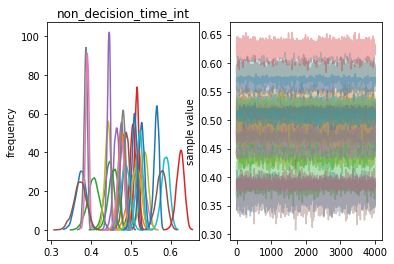

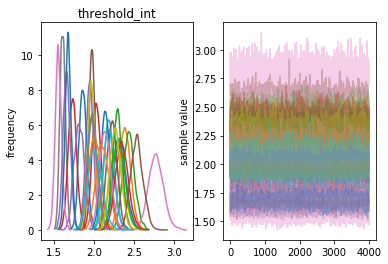

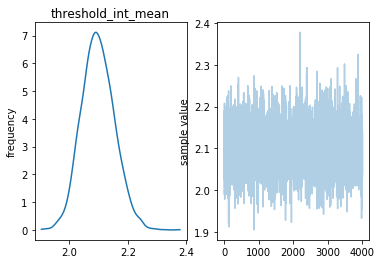

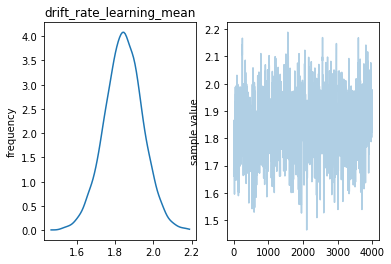

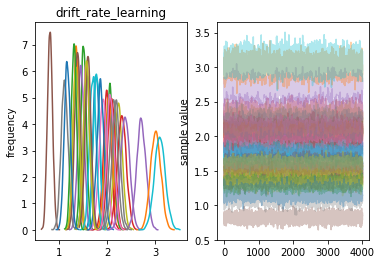

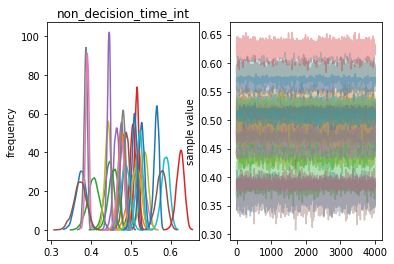

In [6]:
fit.plot('threshold_int')
fit.plot('threshold_int_mean')
fit.plot('drift_rate_learning_mean')
fit.plot('drift_rate_learning')
fit.plot('non_decision_time_int')


In [16]:
print(fit.stansummary(pars=['threshold_int_mean', 'threshold_int_sd', 'drift_rate_learning_mean', 'drift_rate_learning_sd', 'non_decision_time_int']))

Inference for Stan model: model_dual_insight_priorbias_bayesian_3f4b0e8861fe35442899151acfda9b9d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
threshold_int_mean          2.13  7.8e-4   0.05   2.03   2.09   2.13   2.17   2.24   4956    1.0
threshold_int_sd             0.3  6.0e-4   0.04   0.23   0.27    0.3   0.33    0.4   5096    1.0
drift_rate_learning_mean    1.86  4.8e-3    0.1   1.66   1.79   1.86   1.93   2.05    425   1.01
drift_rate_learning_sd      0.54  2.6e-3   0.07   0.41   0.49   0.53   0.58   0.71    852    1.0
non_decision_time_int[1]    0.38  1.7e-4   0.01   0.35   0.37   0.38   0.38    0.4   5534    1.0
non_decision_time_int[2]    0.51  1.8e-4   0.01   0.49   0.51   0.51   0.52   0.54   5505    1.0
non_decision_time_int[3]    0.43  2.2e-4   0.01   0.39   0.42   0.43   0.44   0.45   4572    1.0
non_deci

In [ ]:
# 2. dual influence model
%run stan/sample_dual_bayesian.py

In [17]:
# if fitted, load pickle
model = pickle.load(open('stan/pickles/model_dual_bayesian.pkl', 'rb'))
fit = pickle.load(open('stan/pickles/fit_dual_bayesian.pkl', 'rb'))

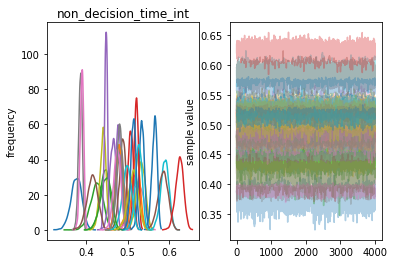

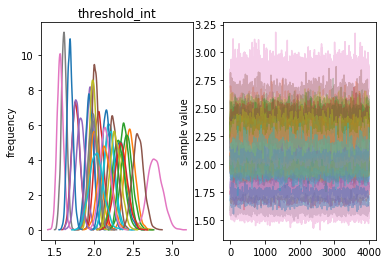

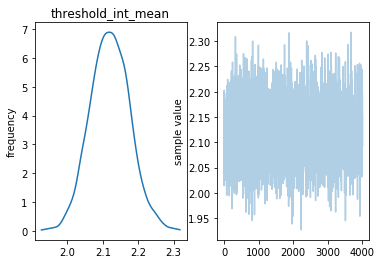

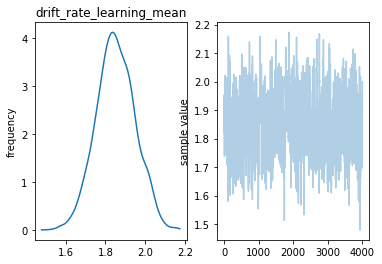

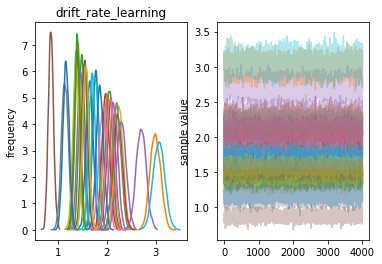

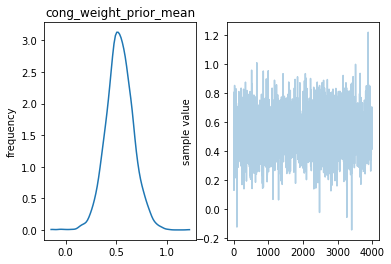

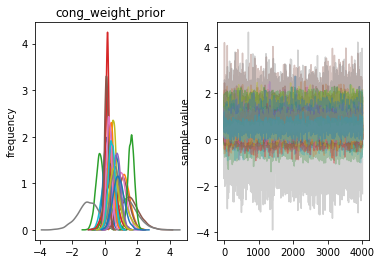

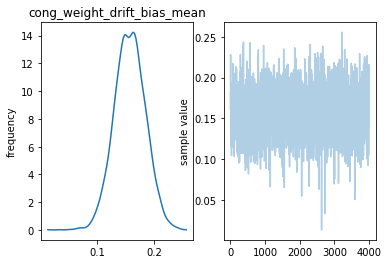

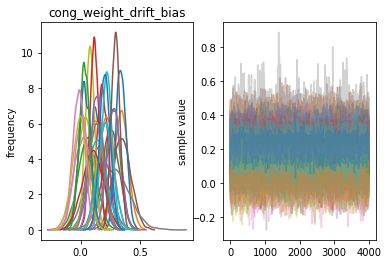

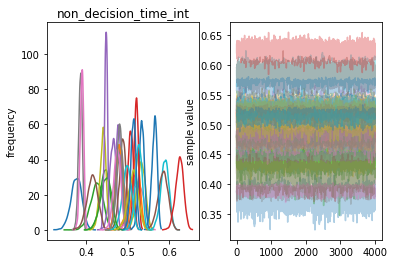

In [15]:
fit.plot('threshold_int')
fit.plot('threshold_int_mean')
fit.plot('drift_rate_learning_mean')
fit.plot('drift_rate_learning')
fit.plot('cong_weight_prior_mean')          
fit.plot('cong_weight_prior')  
fit.plot('cong_weight_drift_bias_mean')     
fit.plot('cong_weight_drift_bias')
fit.plot('non_decision_time_int')


In [18]:
print(fit.stansummary(pars=['threshold_int_mean', 'threshold_int_sd', 'drift_rate_learning_mean', 'drift_rate_learning_sd', 'cong_weight_prior_mean', 'cong_weight_prior_sd',
                            'cong_weight_drift_bias_mean', 'cong_weight_drift_bias_sd','non_decision_time_int']))

Inference for Stan model: model_dual_bayesian_0e83ec402f54bbe4b85063383c9d295c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
threshold_int_mean            2.12  7.2e-4   0.06   2.01   2.08   2.12   2.16   2.23   5877    1.0
threshold_int_sd               0.3  6.4e-4   0.04   0.23   0.27    0.3   0.33    0.4   4733    1.0
drift_rate_learning_mean      1.85  4.0e-3    0.1   1.66   1.79   1.85   1.92   2.04    581   1.01
drift_rate_learning_sd        0.53  2.0e-3   0.07   0.41   0.48   0.52   0.57   0.69   1251    1.0
cong_weight_prior_mean        0.53  3.4e-3   0.13   0.28   0.45   0.53   0.62   0.81   1557    1.0
cong_weight_prior_sd          0.64  4.3e-3   0.15    0.4   0.54   0.63   0.74   0.98   1234    1.0
cong_weight_drift_bias_mean   0.16  6.5e-4   0.03    0.1   0.14   0.16   0.17   0.21   1728    1.0
cong_weigh

In [ ]:
# 3. Dual w/Item popularity influenced prior
# 4. Dual w/Item popularity influenced bias
%run stan/sample_dual_insight_bayesian.py

INFO:pystan:COMPILING THE C++ CODE FOR MODEL model_dual_insight_prior_bayesian_a5f068290117c5bb88cda0180a2f3099 NOW.
/opt/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp2j2jm95o/stanfit4model_dual_insight_prior_bayesian_a5f068290117c5bb88cda0180a2f3099_6185969889046720323.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/jupyter/priorpreferences/analysis_code/stan/sample_dual_insight_bayesian.py:98: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(fit, f)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL model_dual_insight_bias_bayesian_ecadd60a72b9b5c8acc8ce907155f599 NOW.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in or

In [19]:
# if fitted, load pickle
model = pickle.load(open('stan/pickles/model_dual_insight_prior_bayesian.pkl', 'rb'))
fit = pickle.load(open('stan/pickles/fit_dual_insight_prior_bayesian.pkl', 'rb'))

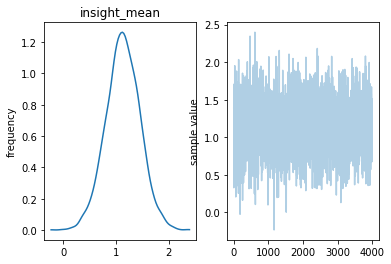

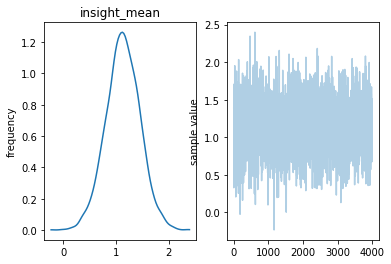

In [7]:
fit.plot('threshold_int')
fit.plot('threshold_int_mean')
fit.plot('drift_rate_learning_mean')
fit.plot('drift_rate_learning')
fit.plot('cong_weight_prior_mean')          
fit.plot('cong_weight_prior')  
fit.plot('cong_weight_drift_bias_mean')     
fit.plot('cong_weight_drift_bias')
fit.plot('non_decision_time_int')
fit.plot('insight_mean')

In [21]:
print(fit.stansummary(pars=['threshold_int_mean', 'threshold_int_sd', 'drift_rate_learning_mean', 'drift_rate_learning_sd', 'cong_weight_prior_mean', 'cong_weight_prior_sd',
                            'cong_weight_drift_bias_mean', 'cong_weight_drift_bias_sd','insight_mean', 'insight_sd','non_decision_time_int']))

Inference for Stan model: model_dual_insight_prior_bayesian_a5f068290117c5bb88cda0180a2f3099.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
threshold_int_mean            2.13  7.0e-4   0.06   2.03   2.09   2.13   2.17   2.25   6504    1.0
threshold_int_sd               0.3  5.9e-4   0.04   0.23   0.27    0.3   0.33    0.4   5552    1.0
drift_rate_learning_mean      1.85  4.1e-3    0.1   1.66   1.79   1.85   1.92   2.04    566   1.01
drift_rate_learning_sd        0.54  1.9e-3   0.07   0.42   0.49   0.53   0.58    0.7   1435    1.0
cong_weight_prior_mean        0.33  3.5e-3   0.15   0.03   0.23   0.32   0.42   0.62   1873    1.0
cong_weight_prior_sd          0.74  3.7e-3   0.15   0.49   0.63   0.72   0.83   1.08   1661    1.0
cong_weight_drift_bias_mean   0.16  6.1e-4   0.03    0.1   0.14   0.16   0.17   0.21   2055    

In [22]:
# if fitted, load pickle
model = pickle.load(open('stan/pickles/model_dual_insight_bias_bayesian.pkl', 'rb'))
fit = pickle.load(open('stan/pickles/fit_dual_insight_bias_bayesian.pkl', 'rb'))

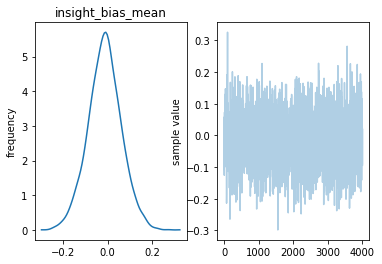

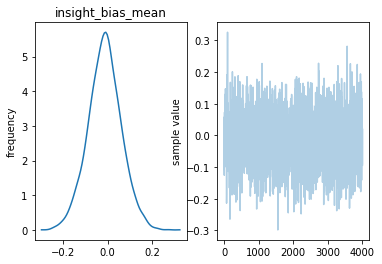

In [9]:
fit.plot('threshold_int')
fit.plot('threshold_int_mean')
fit.plot('drift_rate_learning_mean')
fit.plot('drift_rate_learning')
fit.plot('cong_weight_prior_mean')          
fit.plot('cong_weight_prior')  
fit.plot('cong_weight_drift_bias_mean')     
fit.plot('cong_weight_drift_bias')
fit.plot('non_decision_time_int')
fit.plot('insight_bias_mean')

In [23]:
print(fit.stansummary(pars=['threshold_int_mean', 'threshold_int_sd', 'drift_rate_learning_mean', 'drift_rate_learning_sd', 'cong_weight_prior_mean', 'cong_weight_prior_sd',
                            'cong_weight_drift_bias_mean', 'cong_weight_drift_bias_sd','insight_bias_mean', 'insight_bias_sd']))

Inference for Stan model: model_dual_insight_bias_bayesian_ecadd60a72b9b5c8acc8ce907155f599.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
threshold_int_mean            2.12  8.2e-4   0.06   2.01   2.08   2.12   2.16   2.24   4994    1.0
threshold_int_sd               0.3  7.3e-4   0.04   0.23   0.27    0.3   0.33   0.41   3671    1.0
drift_rate_learning_mean      1.85  5.1e-3    0.1   1.65   1.78   1.85   1.92   2.05    403   1.01
drift_rate_learning_sd        0.53  2.5e-3   0.07   0.41   0.48   0.53   0.58    0.7    888    1.0
cong_weight_prior_mean        0.54  4.1e-3   0.13   0.29   0.45   0.54   0.63    0.8   1032    1.0
cong_weight_prior_sd          0.63  4.4e-3   0.14    0.4   0.53   0.61   0.71   0.94   1046    1.0
cong_weight_drift_bias_mean   0.16  8.9e-4   0.03    0.1   0.14   0.16   0.18   0.22   1293    1

In [1]:
# 5. Dual w/Item popularity influenced prior and bias
%run stan/sample_dual_insight_bayesian.py

INFO:pystan:COMPILING THE C++ CODE FOR MODEL model_dual_insight_priorbias_bayesian_3f4b0e8861fe35442899151acfda9b9d NOW.
/opt/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp41grchba/stanfit4model_dual_insight_priorbias_bayesian_3f4b0e8861fe35442899151acfda9b9d_8936002858361849318.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/jupyter/priorpreferences/analysis_code/stan/sample_dual_insight_bayesian.py:122: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(fit, f)
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limi

In [24]:
# if fitted, load pickle
model = pickle.load(open('stan/pickles/model_dual_insight_priorbias_bayesian.pkl', 'rb'))
fit = pickle.load(open('stan/pickles/fit_dual_insight_priorbias_bayesian.pkl', 'rb'))

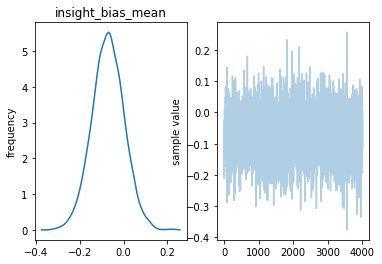

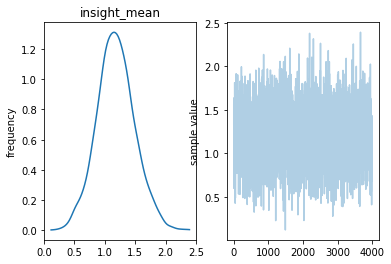

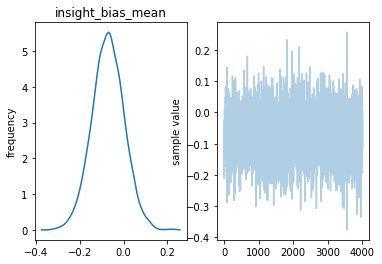

In [11]:
fit.plot('threshold_int')
fit.plot('threshold_int_mean')
fit.plot('drift_rate_learning_mean')
fit.plot('drift_rate_learning')
fit.plot('cong_weight_prior_mean')          
fit.plot('cong_weight_prior')  
fit.plot('cong_weight_drift_bias_mean')     
fit.plot('cong_weight_drift_bias')
fit.plot('non_decision_time_int')
fit.plot('insight_mean')
fit.plot('insight_bias_mean')

In [25]:
print(fit.stansummary(pars=['threshold_int_mean', 'threshold_int_sd', 'drift_rate_learning_mean', 'drift_rate_learning_sd', 'cong_weight_prior_mean', 'cong_weight_prior_sd',
                            'cong_weight_drift_bias_mean', 'cong_weight_drift_bias_sd','insight_mean', 'insight_sd','insight_bias_mean', 'insight_bias_sd']))

Inference for Stan model: model_dual_insight_priorbias_bayesian_3f4b0e8861fe35442899151acfda9b9d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
threshold_int_mean            2.13  7.8e-4   0.05   2.03   2.09   2.13   2.17   2.24   4956    1.0
threshold_int_sd               0.3  6.0e-4   0.04   0.23   0.27    0.3   0.33    0.4   5096    1.0
drift_rate_learning_mean      1.86  4.8e-3    0.1   1.66   1.79   1.86   1.93   2.05    425   1.01
drift_rate_learning_sd        0.54  2.6e-3   0.07   0.41   0.49   0.53   0.58   0.71    852    1.0
cong_weight_prior_mean        0.31  3.9e-3   0.15   0.02   0.21   0.31   0.41   0.61   1508    1.0
cong_weight_prior_sd          0.72  4.0e-3   0.15   0.47   0.62   0.71   0.81   1.06   1398    1.0
cong_weight_drift_bias_mean   0.17  6.9e-4   0.03   0.11   0.15   0.17   0.19   0.23   1906

##<b>Non-social experiment</b>

In [23]:
# 1. null model (non-social)
%run stan/sample_null_bayesian_non_social.py

INFO:pystan:COMPILING THE C++ CODE FOR MODEL model_null_bayesian_non_social_1649474275fde6026e721c32820ce796 NOW.
/opt/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpfskpn2xz/stanfit4model_null_bayesian_non_social_1649474275fde6026e721c32820ce796_702412810751162570.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/jupyter/priorpreferences/analysis_code/stan/sample_null_bayesian_non_social.py:75: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(fit, f)
IOPub data rate exceeded.
The notebook server will temporarily st

In [26]:
# if fitted, load pickle
model = pickle.load(open('stan/pickles/model_null_bayesian_non_social.pkl', 'rb'))
fit = pickle.load(open('stan/pickles/fit_null_bayesian_non_social.pkl', 'rb'))

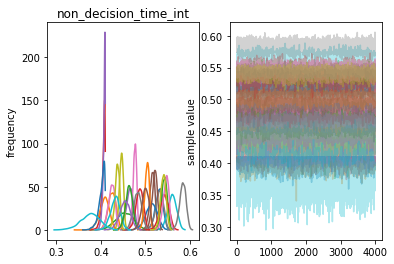

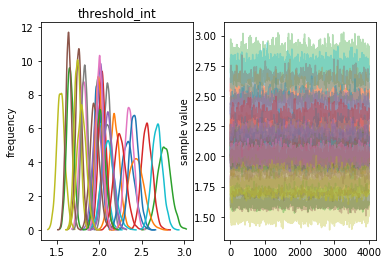

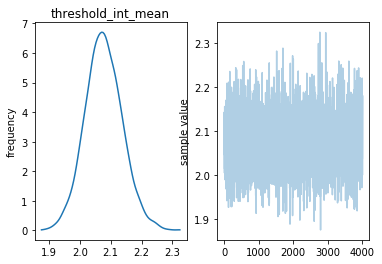

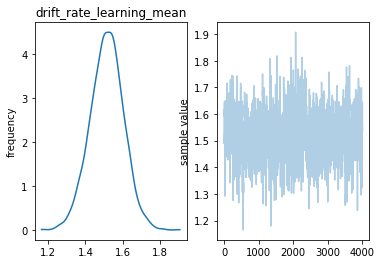

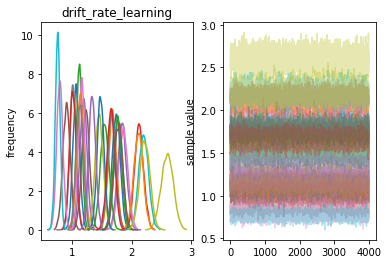

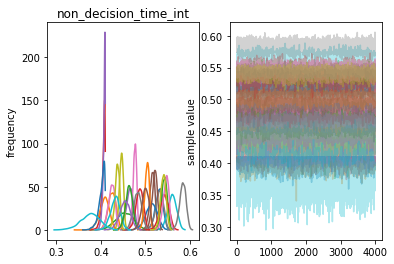

In [24]:
fit.plot('threshold_int')
fit.plot('threshold_int_mean')
fit.plot('drift_rate_learning_mean')
fit.plot('drift_rate_learning')
fit.plot('non_decision_time_int')


In [27]:
print(fit.stansummary(pars=['threshold_int_mean', 'threshold_int_sd', 'drift_rate_learning_mean', 'drift_rate_learning_sd', 'non_decision_time_int']))

Inference for Stan model: model_null_bayesian_non_social_1649474275fde6026e721c32820ce796.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
threshold_int_mean          2.08  8.2e-4   0.06   1.96   2.04   2.08   2.12    2.2   5422    1.0
threshold_int_sd            0.32  7.1e-4   0.05   0.24   0.28   0.31   0.34   0.42   4305    1.0
drift_rate_learning_mean    1.52  3.5e-3   0.09   1.34   1.46   1.52   1.57   1.69    632    1.0
drift_rate_learning_sd      0.48  2.0e-3   0.07   0.37   0.44   0.47   0.52   0.63   1044    1.0
non_decision_time_int[1]    0.53  1.2e-4 8.4e-3   0.51   0.53   0.53   0.54   0.55   5311    1.0
non_decision_time_int[2]    0.42  1.1e-4 8.9e-3   0.41   0.42   0.43   0.43   0.44   6031    1.0
non_decision_time_int[3]    0.45  2.8e-4   0.02   0.41   0.44   0.45   0.47   0.49   4889    1.0
non_decision_ti

In [6]:
# 2. dual influence model (non-social)
%run stan/sample_dual_bayesian_non_social.py

INFO:pystan:COMPILING THE C++ CODE FOR MODEL model_dual_bayesian_non_social_9b17a80e51ff1e772158dac3f05e48fa NOW.
/opt/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpc_af6wp9/stanfit4model_dual_bayesian_non_social_9b17a80e51ff1e772158dac3f05e48fa_565829458975719747.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


FileNotFoundError: [Errno 2] No such file or directory: 'pickles/model_dual_bayesian_non_social.pkl'

In [28]:
# if fitted, load pickle
model = pickle.load(open('stan/pickles/model_dual_bayesian_non_social.pkl', 'rb'))
fit = pickle.load(open('stan/pickles/fit_dual_bayesian_non_social.pkl', 'rb'))

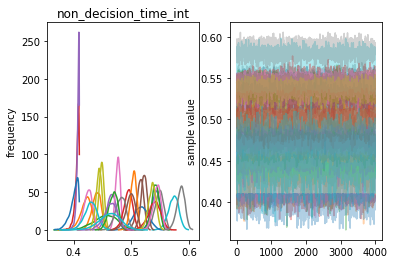

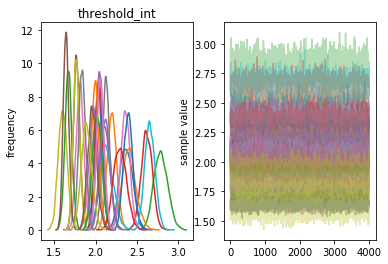

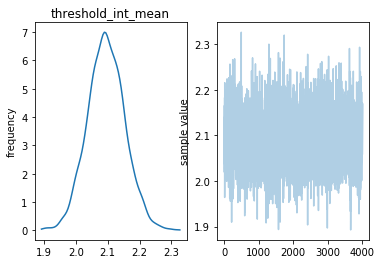

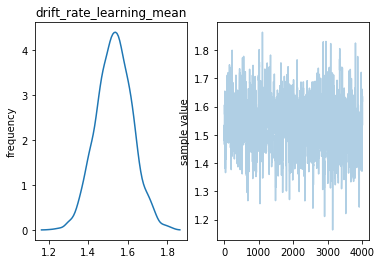

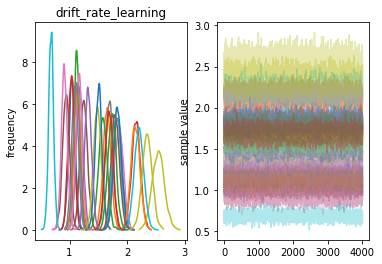

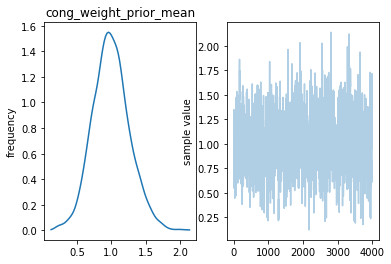

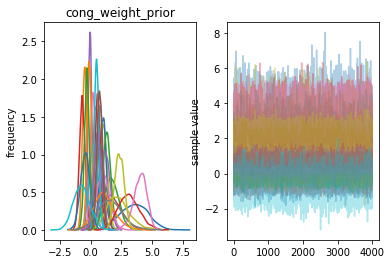

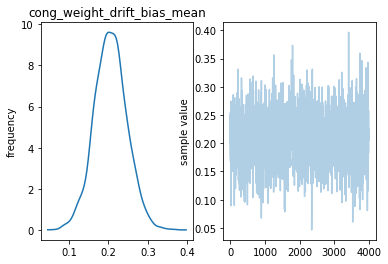

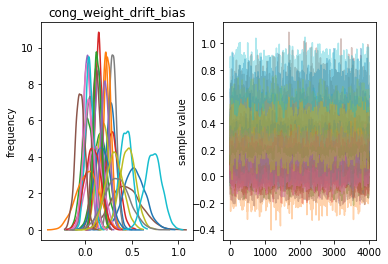

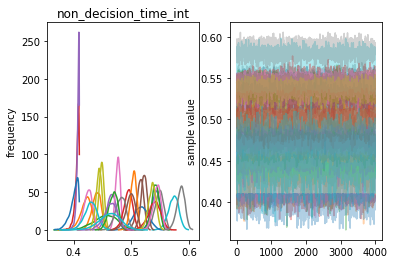

In [9]:
fit.plot('threshold_int')
fit.plot('threshold_int_mean')
fit.plot('drift_rate_learning_mean')
fit.plot('drift_rate_learning')
fit.plot('cong_weight_prior_mean')          
fit.plot('cong_weight_prior')  
fit.plot('cong_weight_drift_bias_mean')     
fit.plot('cong_weight_drift_bias')
fit.plot('non_decision_time_int')


In [30]:
print(fit.stansummary(pars=['threshold_int_mean', 'threshold_int_sd', 'drift_rate_learning_mean', 'drift_rate_learning_sd', 'cong_weight_prior_mean', 'cong_weight_prior_sd',
                            'cong_weight_drift_bias_mean', 'cong_weight_drift_bias_sd']))

Inference for Stan model: model_dual_bayesian_non_social_9b17a80e51ff1e772158dac3f05e48fa.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
threshold_int_mean             2.1  8.7e-4   0.06   1.98   2.06   2.09   2.13   2.21   4553    1.0
threshold_int_sd              0.31  7.6e-4   0.04   0.24   0.28   0.31   0.34   0.41   3425    1.0
drift_rate_learning_mean      1.53  4.5e-3   0.09   1.35   1.47   1.53   1.59   1.71    417   1.01
drift_rate_learning_sd        0.49  2.4e-3   0.07   0.38   0.44   0.49   0.54   0.65    882   1.01
cong_weight_prior_mean         1.0  9.2e-3   0.27    0.5   0.82   0.99   1.16   1.55    843   1.01
cong_weight_prior_sd          1.34  8.2e-3   0.25   0.93   1.17   1.31   1.49   1.91    912    1.0
cong_weight_drift_bias_mean   0.21  1.4e-3   0.04   0.12   0.18   0.21   0.23   0.29    836   1.01

In [ ]:
# 3. Dual w/Item popularity influenced prior (non social)
%run stan/sample_dual_insight_bayesian_non_social.py

INFO:pystan:COMPILING THE C++ CODE FOR MODEL model_dual_insight_prior_bayesian_2a63ea23b7dba7c03d11dc553db78024 NOW.
/opt/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmphtq6sa4b/stanfit4model_dual_insight_prior_bayesian_2a63ea23b7dba7c03d11dc553db78024_5962276256525487085.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [31]:
# if fitted, load pickle
model = pickle.load(open('stan/pickles/model_dual_insight_prior_bayesian.pkl', 'rb'))
fit = pickle.load(open('stan/pickles/fit_dual_insight_prior_bayesian.pkl', 'rb'))

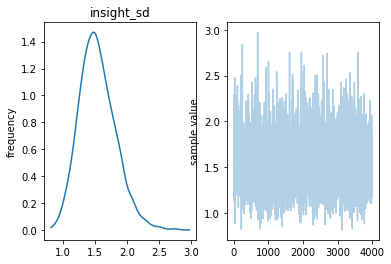

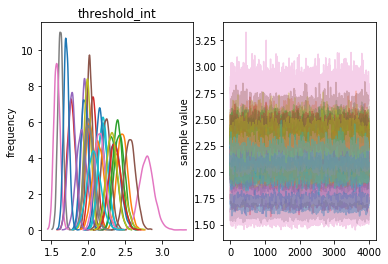

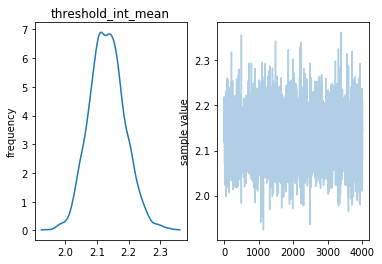

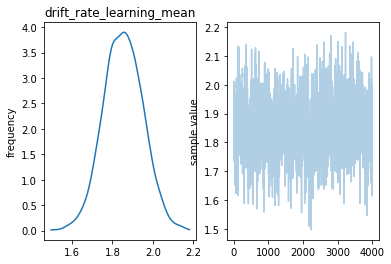

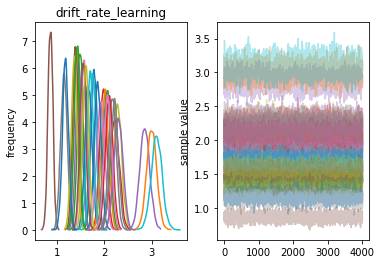

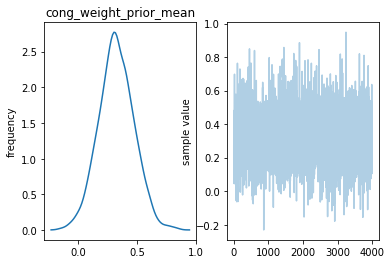

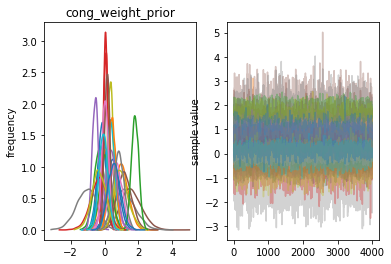

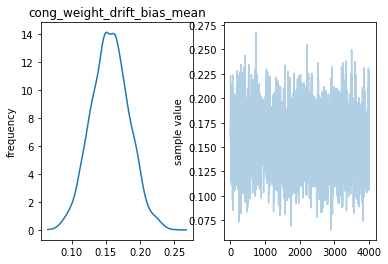

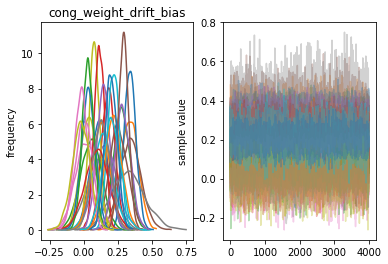

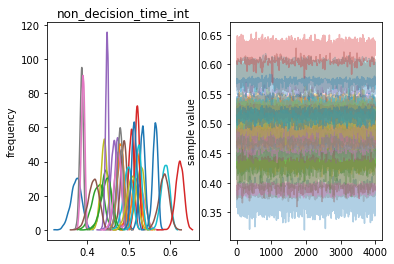

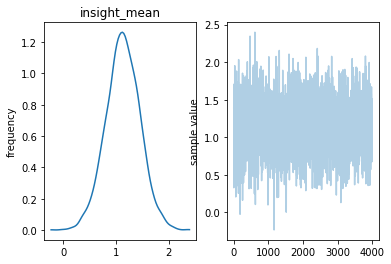

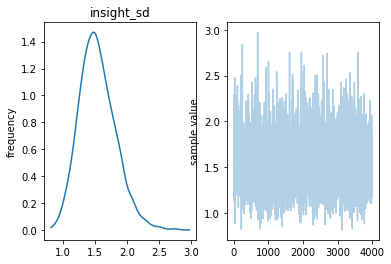

In [32]:
fit.plot('threshold_int')
fit.plot('threshold_int_mean')
fit.plot('drift_rate_learning_mean')
fit.plot('drift_rate_learning')
fit.plot('cong_weight_prior_mean')          
fit.plot('cong_weight_prior')  
fit.plot('cong_weight_drift_bias_mean')     
fit.plot('cong_weight_drift_bias')
fit.plot('non_decision_time_int')
fit.plot('insight_mean')
fit.plot('insight_sd')

In [33]:
print(fit.stansummary(pars=['threshold_int_mean', 'threshold_int_sd', 'drift_rate_learning_mean', 'drift_rate_learning_sd', 'cong_weight_prior_mean', 'cong_weight_prior_sd',
                            'cong_weight_drift_bias_mean', 'cong_weight_drift_bias_sd','insight_mean', 'insight_sd']))

Inference for Stan model: model_dual_insight_prior_bayesian_a5f068290117c5bb88cda0180a2f3099.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
threshold_int_mean            2.13  7.0e-4   0.06   2.03   2.09   2.13   2.17   2.25   6504    1.0
threshold_int_sd               0.3  5.9e-4   0.04   0.23   0.27    0.3   0.33    0.4   5552    1.0
drift_rate_learning_mean      1.85  4.1e-3    0.1   1.66   1.79   1.85   1.92   2.04    566   1.01
drift_rate_learning_sd        0.54  1.9e-3   0.07   0.42   0.49   0.53   0.58    0.7   1435    1.0
cong_weight_prior_mean        0.33  3.5e-3   0.15   0.03   0.23   0.32   0.42   0.62   1873    1.0
cong_weight_prior_sd          0.74  3.7e-3   0.15   0.49   0.63   0.72   0.83   1.08   1661    1.0
cong_weight_drift_bias_mean   0.16  6.1e-4   0.03    0.1   0.14   0.16   0.17   0.21   2055    

We could not run models 4 and 5 for the non-social condition due to lack of time.

In [ ]:
# 4. Dual w/Item popularity influenced bias (non-social)
%run stan/sample_dual_insight_bayesian_non_social.py

In [ ]:
# 5. Dual w/Item popularity influenced prior and bias (non-social)
%run stan/sample_dual_insight_bayesian_non_social.py

Supplementary codes for fitting

In [37]:
# for testing a few subjects
model_data_rt = model_data_rt[0:10]
model_data_correct = model_data_correct[0:10]
model_data_feedback = model_data_feedback[0:10]
model_data_bid_congruence = model_data_bid_congruence[0:10]
model_rt_mins = model_rt_mins[0:10]

In [65]:
# set initial values for each parameter
def initfunc():
    return dict(threshold_int_mean=1,threshold_int_sd=0.5, threshold_int=np.repeat(3,10),
                drift_rate_learning_mean=0.000001, drift_rate_learning_sd_unif=0.000001, drift_rate_learning_raw=np.repeat(0.000001, 10),
                cong_weight_prior_mean=0.000001, cong_weight_prior_sd_unif=0.000001, cong_weight_prior_raw=np.repeat(0.000001, 10),
                cong_weight_drift_bias_mean=0.000001, cong_weight_drift_bias_sd_unif=0.000001, cong_weight_drift_bias_raw=np.repeat(0.000001, 10), 
                ndt_1=0.000001, ndt_2=0.000001, ndt_3=0.000001, ndt_4=0.000001, ndt_5=0.000001, ndt_6=0.000001, ndt_7=0.000001, ndt_8=0.000001, ndt_9=0.000001, ndt_10=0.000001) 
                ndt_11=0.01, ndt_12=0.01, ndt_13=0.01, ndt_14=0.01, ndt_15=0.01, ndt_16=0.01, ndt_17=0.01, ndt_18=0.01, ndt_19=0.01, ndt_20=0.01,
                ndt_21=0.01, ndt_22=0.01, ndt_23=0.01, ndt_24=0.01, ndt_25=0.01, ndt_26=0.01, ndt_27=0.01, ndt_28=0.01, ndt_29=0.01, ndt_30=0.01, ndt_31=0.01)

In [ ]:
# plots
fit.plot('threshold_int')
fit.plot('threshold_int_mean')
fit.plot('drift_rate_learning_mean')
fit.plot('drift_rate_learning')
fit.plot('cong_weight_prior_mean')          
fit.plot('cong_weight_prior')  
fit.plot('cong_weight_drift_bias_mean')     
fit.plot('cong_weight_drift_bias')
fit.plot('non_decision_time_int')

In [ ]:
# plots using arviz (need to improve)
az.plot_density(fit, var_names=['threshold_int', 'threshold_int_mean']);
data = az.from_pystan(posterior=fit,
                      posterior_predictive='y_hat',
                      observed_data=['y'],
                      log_likelihood='log_lik',
                      coords={'school': schools},
                      dims={'theta': ['school'], 'y': ['school'], 'log_lik': ['school'], 'y_hat': ['school'], 'theta_tilde': ['school']})
data
az.plot_pair(data, coords={'school': ['Choate', 'Deerfield', 'Phillips Andover']}, divergences=True);    #school=subjects

###<b>Model Comparison (Social experiment, Bayesian)</b>

<b>Null model (Bayesian)</b>

In [4]:
#Load Stan model and fit
model_null_bayesian = pickle.load(open('stan/pickles/model_null_bayesian.pkl', 'rb'))
fit_null_bayesian = pickle.load(open('stan/pickles/fit_null_bayesian.pkl', 'rb'))

# Load log-likelihood matrix for response data from Stan fit generated quantitites
LL_null_bayesian = pd.DataFrame(fit_null_bayesian['log_lik_rt'])

# Drop trials with no RT data (i.e. NaN and -inf likelihoods)
null_index = pd.isnull(LL_null_bayesian).any(0).to_numpy().nonzero()[0]
LL_null_bayesian.drop(LL_null_bayesian.columns[null_index], axis=1, inplace=True)

LL_null_bayesian_mean = LL_null_bayesian.mean(axis=0)
inf_index = np.where(np.isinf(LL_null_bayesian_mean))[0]
LL_null_bayesian.drop(LL_null_bayesian.columns[inf_index], axis=1, inplace=True)
LL_null_bayesian.columns = range((18600 - len(null_index) - len(inf_index)))

# Convert to R dataframe-> matrix
pandas2ri.activate()
r_df = pandas2ri.py2ri(LL_null_bayesian)

# Push to R
%Rpush r_df

In [5]:
%%R
library("rstan")
library("loo")
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

R_LL_null_bayesian=as.matrix(r_df)
loo_null_bayesian <- loo(R_LL_null_bayesian)
print(loo_null_bayesian)


Computed from 4000 by 18596 log-likelihood matrix

         Estimate    SE
elpd_loo  -8546.1 217.5
p_loo       300.8  33.6
looic     17092.2 434.9
------
Monte Carlo SE of elpd_loo is NA.

Pareto k diagnostic values:
                         Count Pct.    Min. n_eff
(-Inf, 0.5]   (good)     18552 99.8%   863       
 (0.5, 0.7]   (ok)           9  0.0%   361       
   (0.7, 1]   (bad)          6  0.0%   21        
   (1, Inf)   (very bad)    29  0.2%   4         
See help('pareto-k-diagnostic') for details.


<b>Dual influence (Bayesian)</b>

In [8]:
#Load Stan model and fit
model_dual_bayesian = pickle.load(open('stan/pickles/model_dual_bayesian.pkl', 'rb'))
fit_dual_bayesian = pickle.load(open('stan/pickles/fit_dual_bayesian.pkl', 'rb'))

# Load log-likelihood matrix for response data from Stan fit generated quantitites
LL_dual_bayesian = pd.DataFrame(fit_dual_bayesian['log_lik_rt'])

# Drop trials with no RT data (i.e. NaN and -inf likelihoods)
null_index = pd.isnull(LL_dual_bayesian).any(0).to_numpy().nonzero()[0]
LL_dual_bayesian.drop(LL_dual_bayesian.columns[null_index], axis=1, inplace=True)

LL_dual_bayesian_mean = LL_dual_bayesian.mean(axis=0)
inf_index = np.where(np.isinf(LL_dual_bayesian_mean))[0]
LL_dual_bayesian.drop(LL_dual_bayesian.columns[inf_index], axis=1, inplace=True)
LL_dual_bayesian.columns = range((18600 - len(null_index) - len(inf_index)))

# Convert to R dataframe-> matrix
pandas2ri.activate()
r_df = pandas2ri.py2ri(LL_dual_bayesian)

# Push to R
%Rpush r_df

In [9]:
%%R
library("rstan")
library("loo")
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

R_LL_dual_bayesian=as.matrix(r_df)
loo_dual_bayesian <- loo(R_LL_dual_bayesian)
print(loo_dual_bayesian)


Computed from 4000 by 18596 log-likelihood matrix

         Estimate    SE
elpd_loo  -8284.8 217.9
p_loo       379.5  35.1
looic     16569.6 435.9
------
Monte Carlo SE of elpd_loo is NA.

Pareto k diagnostic values:
                         Count Pct.    Min. n_eff
(-Inf, 0.5]   (good)     18551 99.8%   380       
 (0.5, 0.7]   (ok)           8  0.0%   301       
   (0.7, 1]   (bad)          8  0.0%   21        
   (1, Inf)   (very bad)    29  0.2%   5         
See help('pareto-k-diagnostic') for details.


In [19]:
# python version of loo
idata = az.from_pystan(fit_dual_bayesian_noeye, log_likelihood="log_lik_rt")
loo=az.loo(idata)
print(loo)

/opt/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:582: RuntimeWarning: invalid value encountered in greater
  tailinds, = np.where(x > xcutoff)  # pylint: disable=unbalanced-tuple-unpacking
/opt/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:442: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Compare "null" and "dual influence" models:

In [28]:
%%R
print(loo_compare(x=list(loo_null_bayesian, loo_dual_bayesian))

       elpd_diff se_diff
model3     0.0       0.0
model2 -1488.3     104.5
model1 -1749.6     104.6


The dual influence model is significantly more predictive than the null model.<br>

<b>Dual influence w/popularity influence on prior (Bayesian)</b>

In [12]:
#Load Stan model and fit
model_dual_insight_prior_bayesian = pickle.load(open('stan/pickles/model_dual_insight_prior_bayesian.pkl', 'rb'))
fit_dual_insight_prior_bayesian = pickle.load(open('stan/pickles/fit_dual_insight_prior_bayesian.pkl', 'rb'))

# Load log-likelihood matrix for response data from Stan fit generated quantitites
LL_dual_insight_prior_bayesian = pd.DataFrame(fit_dual_insight_prior_bayesian['log_lik_rt'])

# Drop trials with no RT data (i.e. NaN and -inf likelihoods)
null_index = pd.isnull(LL_dual_insight_prior_bayesian).any(0).to_numpy().nonzero()[0]
LL_dual_insight_prior_bayesian.drop(LL_dual_insight_prior_bayesian.columns[null_index], axis=1, inplace=True)

LL_dual_insight_prior_bayesian_mean = LL_dual_insight_prior_bayesian.mean(axis=0)
inf_index = np.where(np.isinf(LL_dual_insight_prior_bayesian_mean))[0]
LL_dual_insight_prior_bayesian.drop(LL_dual_insight_prior_bayesian.columns[inf_index], axis=1, inplace=True)
LL_dual_insight_prior_bayesian.columns = range((18600 - len(null_index) - len(inf_index)))

# Convert to R dataframe-> matrix
pandas2ri.activate()
r_df = pandas2ri.py2ri(LL_dual_insight_prior_bayesian)

# Push to R
%Rpush r_df

In [13]:
%%R
library("rstan")
library("loo")
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

R_LL_dual_insight_prior_bayesian=as.matrix(r_df)
loo_dual_insight_prior_bayesian <- loo(R_LL_dual_insight_prior_bayesian)
print(loo_dual_insight_prior_bayesian)


Computed from 4000 by 18596 log-likelihood matrix

         Estimate    SE
elpd_loo  -6796.5 205.2
p_loo       477.2  50.0
looic     13593.0 410.4
------
Monte Carlo SE of elpd_loo is NA.

Pareto k diagnostic values:
                         Count Pct.    Min. n_eff
(-Inf, 0.5]   (good)     18550 99.8%   594       
 (0.5, 0.7]   (ok)           9  0.0%   147       
   (0.7, 1]   (bad)          5  0.0%   32        
   (1, Inf)   (very bad)    32  0.2%   2         
See help('pareto-k-diagnostic') for details.


Does adding insight improve the predictiveness of the model via influence on prior?

In [22]:
%%R
loo_diff <- loo_compare(loo_dual_bayesian, loo_dual_insight_prior_bayesian)
print(loo_diff)

       elpd_diff se_diff
model2     0.0       0.0
model1 -1488.3     104.5


Yes, it does, to a significant degree.

<b>Dual influence w/popularity influence on bias (Bayesian)</b>

In [2]:
#Load Stan model and fit
model_dual_insight_bias_bayesian = pickle.load(open('stan/pickles/model_dual_insight_bias_bayesian.pkl', 'rb'))
fit_dual_insight_bias_bayesian= pickle.load(open('stan/pickles/fit_dual_insight_bias_bayesian.pkl', 'rb'))

# Load log-likelihood matrix for response data from Stan fit generated quantitites
LL_dual_insight_bias_bayesian = pd.DataFrame(fit_dual_insight_bias_bayesian['log_lik_rt'])

# Drop trials with no RT data (i.e. NaN and -inf likelihoods)
null_index = pd.isnull(LL_dual_insight_bias_bayesian).any(0).to_numpy().nonzero()[0]
LL_dual_insight_bias_bayesian.drop(LL_dual_insight_bias_bayesian.columns[null_index], axis=1, inplace=True)

LL_dual_insight_bias_bayesian_mean = LL_dual_insight_bias_bayesian.mean(axis=0)
inf_index = np.where(np.isinf(LL_dual_insight_bias_bayesian_mean))[0]
LL_dual_insight_bias_bayesian.drop(LL_dual_insight_bias_bayesian.columns[inf_index], axis=1, inplace=True)
LL_dual_insight_bias_bayesian.columns = range((18600 - len(null_index) - len(inf_index)))

# Convert to R dataframe-> matrix
pandas2ri.activate()
r_df = pandas2ri.py2ri(LL_dual_insight_bias_bayesian)

# Push to R
%Rpush r_df

In [3]:
%%R
library("rstan")
library("loo")
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

R_LL_dual_insight_bias_bayesian=as.matrix(r_df)
loo_dual_insight_bias_bayesian <- loo(R_LL_dual_insight_bias_bayesian)
print(loo_dual_insight_bias_bayesian)

/opt/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: StanHeaders

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: rstan (Version 2.17.3, GitRev: 2e1f913d3ca3)

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: This is loo version 2.1.0.
**NOTE: As of ve


Computed from 4000 by 18596 log-likelihood matrix

         Estimate    SE
elpd_loo  -6685.3 204.0
p_loo       441.4  50.4
looic     13370.5 407.9
------
Monte Carlo SE of elpd_loo is NA.

Pareto k diagnostic values:
                         Count Pct.    Min. n_eff
(-Inf, 0.5]   (good)     18546 99.7%   691       
 (0.5, 0.7]   (ok)          13  0.1%   141       
   (0.7, 1]   (bad)          7  0.0%   27        
   (1, Inf)   (very bad)    30  0.2%   1         
See help('pareto-k-diagnostic') for details.


Does adding insight improve the predictiveness of the model?

In [17]:
%%R
loo_diff <- loo_compare(loo_dual_insight_prior_bayesian, loo_dual_insight_bias_bayesian)
print(loo_diff)


Error in compare(loo_dual_insight_prior_bayesian, loo_dual_insight_bias_bayesian) : 
  object 'loo_dual_insight_bias_bayesian' not found


<b>Dual influence w/popularity influence on prior and bias (Bayesian)</b>

In [18]:
#Load Stan model and fit
model_dual_insight_priorbias_bayesian = pickle.load(open('stan/pickles/model_dual_insight_priorbias_bayesian.pkl', 'rb'))
fit_dual_insight_priorbias_bayesian = pickle.load(open('stan/pickles/fit_dual_insight_priorbias_bayesian.pkl', 'rb'))

# Load log-likelihood matrix for response data from Stan fit generated quantitites
LL_dual_insight_priorbias_bayesian = pd.DataFrame(fit_dual_insight_priorbias_bayesian['log_lik_rt'])

# Drop trials with no RT data (i.e. NaN and -inf likelihoods)
null_index = pd.isnull(LL_dual_insight_priorbias_bayesian).any(0).to_numpy().nonzero()[0]
LL_dual_insight_priorbias_bayesian.drop(LL_dual_insight_priorbias_bayesian.columns[null_index], axis=1, inplace=True)

LL_dual_insight_priorbias_bayesian_mean = LL_dual_insight_priorbias_bayesian.mean(axis=0)
inf_index = np.where(np.isinf(LL_dual_insight_priorbias_bayesian_mean))[0]
LL_dual_insight_priorbias_bayesian.drop(LL_dual_insight_priorbias_bayesian.columns[inf_index], axis=1, inplace=True)
LL_dual_insight_priorbias_bayesian.columns = range((18600 - len(null_index) - len(inf_index)))

# Convert to R dataframe-> matrix
pandas2ri.activate()
r_df = pandas2ri.py2ri(LL_dual_insight_bias_bayesian)

# Push to R
%Rpush r_df

In [19]:
%%R
library("rstan")
library("loo")
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

R_LL_dual_insight_priorbias_bayesian=as.matrix(r_df)
loo_dual_insight_priorbias_bayesian <- loo(R_LL_dual_insight_priorbias_bayesian)
print(loo_dual_insight_priorbias_bayesian)


Computed from 4000 by 18596 log-likelihood matrix

         Estimate    SE
elpd_loo  -6685.3 204.0
p_loo       441.4  50.4
looic     13370.5 407.9
------
Monte Carlo SE of elpd_loo is NA.

Pareto k diagnostic values:
                         Count Pct.    Min. n_eff
(-Inf, 0.5]   (good)     18546 99.7%   691       
 (0.5, 0.7]   (ok)          13  0.1%   141       
   (0.7, 1]   (bad)          7  0.0%   27        
   (1, Inf)   (very bad)    30  0.2%   1         
See help('pareto-k-diagnostic') for details.


Does adding insight improve the predictiveness of the model?

In [ ]:
%%R
loo_diff <- compare(loo_dual_insight_bias_bayesian_noeye, loo_dual_bayesian_noeye)
print(loo_diff)

###Model comparison (non-social experiment)

Now we do the same model comparisons for the non-social experiment group.

<b>Null model (Bayesian)</b>

In [3]:
# Null Drift Model (Bayesian)

#Load Stan model and fit
model_null_bayesian_non_social = pickle.load(open('stan/pickles/model_null_bayesian_non_social.pkl', 'rb'))
fit_null_bayesian_non_social = pickle.load(open('stan/pickles/fit_null_bayesian_non_social.pkl', 'rb'))

# Load log-likelihood matrix for response data from Stan fit generated quantitites
LL_null_bayesian_non_social = pd.DataFrame(fit_null_bayesian_non_social['log_lik_rt'])

# Drop trials with no RT data (i.e. NaN and -inf likelihoods)
null_index = pd.isnull(LL_null_bayesian_non_social).any(0).to_numpy().nonzero()[0]
LL_null_bayesian_non_social.drop(LL_null_bayesian_non_social.columns[null_index], axis=1, inplace=True)

LL_null_bayesian_non_social_mean = LL_null_bayesian_non_social.mean(axis=0)
inf_index = np.where(np.isinf(LL_null_bayesian_non_social_mean))[0]
LL_null_bayesian_non_social.drop(LL_null_bayesian_non_social.columns[inf_index], axis=1, inplace=True)
LL_null_bayesian_non_social.columns = range((18600 - len(null_index) - len(inf_index)))

# Convert to R dataframe-> matrix
pandas2ri.activate()
r_df = pandas2ri.py2ri(LL_null_bayesian_non_social)

# Push to R
%Rpush r_df

In [ ]:
%%R
library("rstan")
library("loo")
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

R_LL_null_bayesian_non_social=as.matrix(r_df)
loo_null_bayesian_non_social <- loo(R_LL_null_bayesian_non_social)
print(loo_null_bayesian_non_social)

<b>Dual influence (Bayesian)</b>

In [ ]:
# Dual Influence Model (Bayesian)

#Load Stan model and fit
model_dual_bayesian_non_social = pickle.load(open('stan/pickles/model_dual_bayesian_non_social.pkl', 'rb'))
fit_dual_bayesian_non_social = pickle.load(open('stan/pickles/fit_dual_bayesian_non_social.pkl', 'rb'))

# Load log-likelihood matrix for response data from Stan fit generated quantitites
LL_dual_bayesian_non_social = pd.DataFrame(fit_dual_bayesian_non_social['log_lik_rt'])

# Drop trials with no RT data (i.e. NaN and -inf likelihoods)
null_index = pd.isnull(LL_dual_bayesian_non_social).any(0).to_numpy().nonzero()[0]
LL_dual_bayesian_non_social.drop(LL_dual_bayesian_non_social.columns[null_index], axis=1, inplace=True)

LL_dual_bayesian_non_social_mean = LL_dual_bayesian_non_social.mean(axis=0)
inf_index = np.where(np.isinf(LL_dual_bayesian_non_social_mean))[0]
LL_dual_bayesian_non_social.drop(LL_dual_bayesian_non_social.columns[inf_index], axis=1, inplace=True)
LL_dual_bayesian_non_social.columns = range((18000 - len(null_index) - len(inf_index)))

# Convert to R matrix
R_LL_dual_bayesian_non_social = com.convert_to_r_matrix(LL_dual_bayesian_non_social)

Push to R
%Rpush R_LL_dual_bayesian_non_social

In [ ]:
%%R
library("rstan")
library("loo")
loo_dual_bayesian_non_social <- loo(R_LL_dual_bayesian_non_social)
print(loo_dual_bayesian_non_social)

Is the dual influence model significantly more predictive than the second-best, influenced choice model?

In [ ]:
%%R
loo_diff <- compare(loo_null_bayesian_non_social, loo_dual_bayesian_non_social)
print(loo_diff)

<b>Dual influence w/popularity influence on prior (Bayesian)</b>

In [ ]:
# Influenced Dual Influence w/Insight Model (Bayesian)

#Load Stan model and fit
model_dual_insight_prior_bayesian_non_social = pickle.load(open('stan/pickles/model_dual_insight_prior_bayesian_non_social.pkl', 'rb'))
fit_dual_insight_prior_bayesian_non_social = pickle.load(open('stan/pickles/fit_dual_insight_prior_bayesian_non_social.pkl', 'rb'))

# Load log-likelihood matrix for response data from Stan fit generated quantitites
LL_dual_insight_prior_bayesian_non_social = pd.DataFrame(fit_dual_insight_prior_bayesian_non_social['log_lik_rt'])

# Drop trials with no RT data (i.e. NaN and -inf likelihoods)
null_index = pd.isnull(LL_dual_insight_prior_bayesian_non_social).any(0).to_numpy().nonzero()[0]
LL_dual_insight_prior_bayesian_non_social.drop(LL_dual_insight_prior_bayesian_non_social.columns[null_index], axis=1, inplace=True)

LL_dual_insight_prior_bayesian_non_social_mean = LL_dual_insight_prior_bayesian_non_social.mean(axis=0)
inf_index = np.where(np.isinf(LL_dual_insight_prior_bayesian_non_social_mean))[0]
LL_dual_insight_prior_bayesian_non_social.drop(LL_dual_insight_prior_bayesian_non_social.columns[inf_index], axis=1, inplace=True)
LL_dual_insight_prior_bayesian_non_social.columns = range((18000 - len(null_index) - len(inf_index)))

# Convert to R matrix
R_LL_dual_insight_prior_bayesian_non_social = com.convert_to_r_matrix(LL_dual_insight_prior_bayesian_non_social)

# Push to R
%Rpush R_LL_dual_insight_prior_bayesian_non_social

In [ ]:
%%R
library("rstan")
library("loo")
loo_dual_insight_prior_bayesian_non_social <- loo(R_LL_dual_insight_prior_bayesian_non_social)
print(loo_dual_insight_prior_bayesian_non_social)

Does item popularity improve the dual influence model in the non-social group?

In [ ]:
%%R
loo_diff <- compare(loo_dual_bayesian_non_social, loo_dual_insight_prior_bayesian_non_social)
print(loo_diff)

<b>Dual influence w/popularity influence on bias (Bayesian)</b>

In [ ]:
# Influenced Dual Influence w/Insight Model (Bayesian)

#Load Stan model and fit
model_dual_insight_bias_bayesian_non_social = pickle.load(open('stan/pickles/model_dual_insight_bias_bayesian_non_social.pkl', 'rb'))
fit_dual_insight_bias_bayesian_non_social = pickle.load(open('stan/pickles/fit_dual_insight_bias_bayesian_non_social.pkl', 'rb'))

# Load log-likelihood matrix for response data from Stan fit generated quantitites
LL_dual_insight_bias_bayesian_non_social = pd.DataFrame(fit_dual_insight_bias_bayesian_non_social['log_lik_rt'])

# Drop trials with no RT data (i.e. NaN and -inf likelihoods)
null_index = pd.isnull(LL_dual_insight_bias_bayesian_non_social).any(0).to_numpy().nonzero()[0]
LL_dual_insight_bias_bayesian_non_social.drop(LL_dual_insight_bias_bayesian_non_social.columns[null_index], axis=1, inplace=True)

LL_dual_insight_bias_bayesian_non_social_mean = LL_dual_insight_bias_bayesian_non_social.mean(axis=0)
inf_index = np.where(np.isinf(LL_dual_insight_bias_bayesian_non_social_mean))[0]
LL_dual_insight_bias_bayesian_non_social.drop(LL_dual_insight_bias_bayesian_non_social.columns[inf_index], axis=1, inplace=True)
LL_dual_insight_bias_bayesian_non_social.columns = range((18000 - len(null_index) - len(inf_index)))

# Convert to R matrix
R_LL_dual_insight_bias_bayesian_non_social = com.convert_to_r_matrix(LL_dual_insight_bias_bayesian_non_social)

# Push to R
%Rpush R_LL_dual_insight_bias_bayesian_non_social

In [ ]:
%%R
library("rstan")
library("loo")
loo_dual_insight_bias_bayesian_non_social <- loo(R_LL_dual_insight_bias_bayesian_non_social)
print(loo_dual_insight_bias_bayesian_non_social)

Does item popularity improve the dual influence model in the non-social group?

In [ ]:
%%R
loo_diff <- compare(loo_dual_insight_prior_bayesian_non_social, loo_dual_insight_bias_bayesian_non_social)
print(loo_diff)

<b>Dual influence w/popularity influence on prior and bias (Bayesian)</b>

In [ ]:
# Influenced Dual Influence w/Insight Model (Bayesian)

#Load Stan model and fit
model_dual_insight_priorbias_bayesian_non_social = pickle.load(open('stan/pickles/model_dual_insight_priorbias_bayesian_non_social.pkl', 'rb'))
fit_dual_insight_priorbias_bayesian_non_social = pickle.load(open('stan/pickles/fit_dual_insight_priorbias_bayesian_non_social.pkl', 'rb'))

# Load log-likelihood matrix for response data from Stan fit generated quantitites
LL_dual_insight_priorbias_bayesian_non_social = pd.DataFrame(fit_dual_insight_priorbias_bayesian_non_social['log_lik_rt'])

# Drop trials with no RT data (i.e. NaN and -inf likelihoods)
null_index = pd.isnull(LL_dual_insight_priorbias_bayesian_non_social).any(0).to_numpy().nonzero()[0]
LL_dual_insight_priorbias_bayesian_non_social.drop(LL_dual_insight_priorbias_bayesian_non_social.columns[null_index], axis=1, inplace=True)

LL_dual_insight_priorbias_bayesian_non_social_mean = LL_dual_insight_priorbias_bayesian_non_social.mean(axis=0)
inf_index = np.where(np.isinf(LL_dual_insight_priorbias_bayesian_non_social_mean))[0]
LL_dual_insight_priorbias_bayesian_non_social.drop(LL_dual_insight_priorbias_bayesian_non_social.columns[inf_index], axis=1, inplace=True)
LL_dual_insight_priorbias_bayesian_non_social.columns = range((18000 - len(null_index) - len(inf_index)))

# Convert to R matrix
R_LL_dual_insight_priorbias_bayesian_non_social = com.convert_to_r_matrix(LL_dual_insight_priorbias_bayesian_non_social)

# Push to R
%Rpush R_LL_dual_insight_priorbias_bayesian_non_social

In [ ]:
%%R
library("rstan")
library("loo")
loo_dual_insight_priorbias_bayesian_non_social <- loo(R_LL_dual_insight_priorbias_bayesian_non_social)
print(loo_dual_insight_priorbias_bayesian_non_social)

Does item popularity improve the dual influence model in the non-social group?

In [ ]:
%%R
loo_diff <- compare(loo_dual_insight_bias_bayesian_non_social, loo_dual_insight_priorbias_bayesian_non_social)
print(loo_diff)

###Figure 1: LOO comparisons

In [ ]:
plt.subplot?

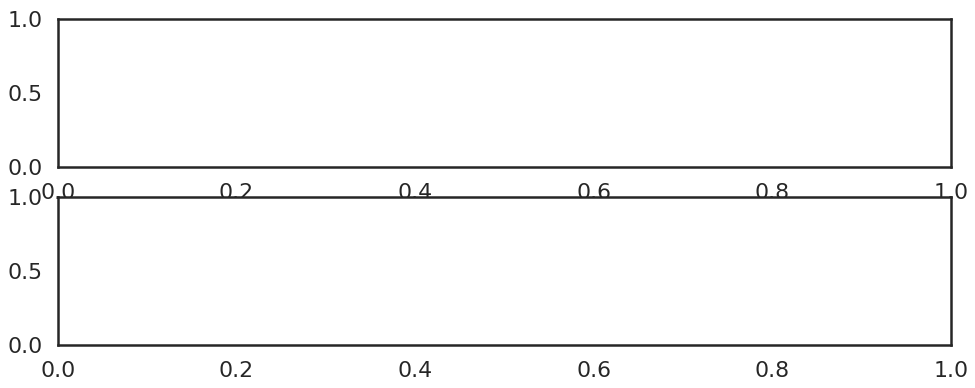

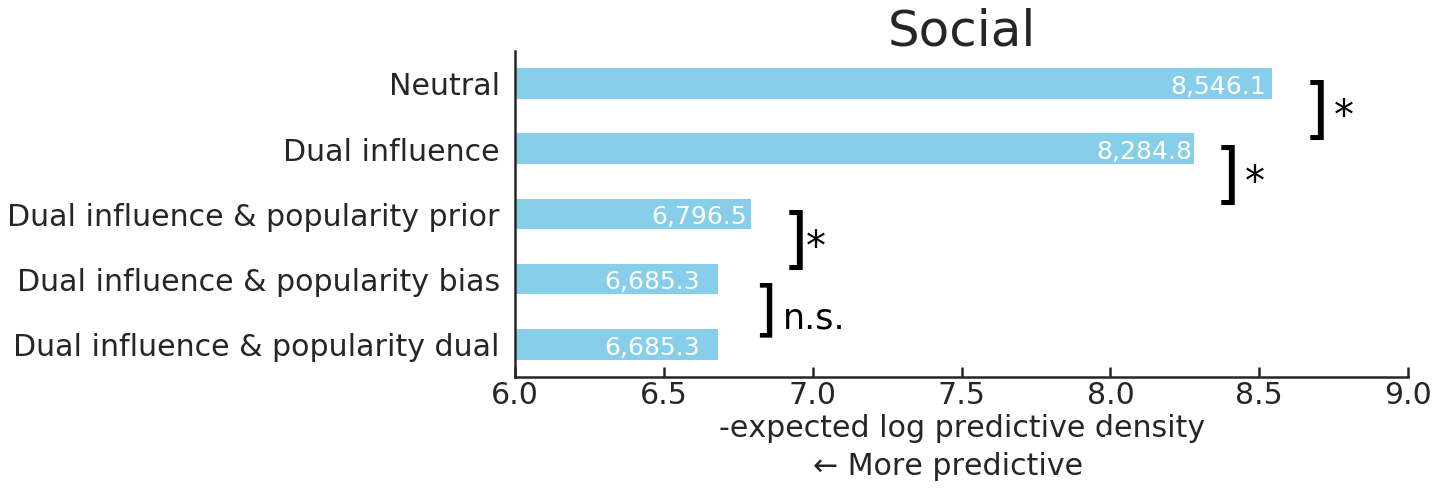

In [52]:
# Bayesian Social panel
fig, ax = pl.subplots(2,1,squeeze=False)
sns.set_context("poster")
sns.set_style("white", {"grid.linewidth": 0})
pl.rcParams['figure.figsize'] = (16.0, 6.0)

# Social
#ax1 = plt.subplot(211)
comparison_labels = ['Dual influence & popularity dual','Dual influence & popularity bias','Dual influence & popularity prior','Dual influence', 'Neutral']
comparison_elpds = [6685.3, 6685.3, 6796.5, 8284.8, 8546.1]
comparison_errors = [204.0, 204.0, 205.2, 217.9, 217.5]
xticklabels = ['6.0','6.5','7.0','7.5','8.0','8.5','9.0']
ax[0,0] = pd.DataFrame(comparison_elpds,index=comparison_labels).plot(kind='barh', legend=False, xlim=[7950,8350], fontsize=30, color=['skyblue','grey','grey','grey','grey'])
ax[0,0].set_title(u'Social', size=50)
ax[0,0].set_xticks([6000,6500,7000,7500,8000,8500,9000])
ax[0,0].set_xticklabels(xticklabels)
ax[0,0].set_xlabel(u'-expected log predictive density', size=30)
ax[0,0].text(7000, -2, u'\u2190 More predictive', size=30)
ax[0,0].xaxis.set_tick_params(size=10)
ax[0,0].xaxis.set_ticks_position('bottom')
ax[0,0].tick_params(axis='x', direction='in')
ax[0,0].text(8200,3.85,'8,546.1', size=25, color='white')

ax[0,0].text(8650,3.3,']', size=65, color='black')
ax[0,0].text(8750.2,3.3,'*', size=40, color='black')

ax[0,0].text(7953,2.85,'8,284.8', size=25, color='white')

ax[0,0].text(8350,2.3,']', size=65, color='black')
ax[0,0].text(8450.2,2.3,'*', size=40, color='black')

ax[0,0].text(6458,1.85,'6,796.5', size=25, color='white')

ax[0,0].text(6900,1.3,']', size=65, color='black')
ax[0,0].text(6975.2,1.3,'*', size=40, color='black')

ax[0,0].text(6300,0.85,'6,685.3', size=25, color='white')

ax[0,0].text(6800.1,0.25,']', size=60, color='black')
ax[0,0].text(6900.1,0.25,'n.s.', size=35, color='black')

ax[0,0].text(6300,-0.15,'6,685.3', size=25, color='white')
ax[0,0].text(7977,-1.5,'--', size=25, color='white') # Add some space between plots

ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)

# Save figure
plt.savefig('../figures/fig1-loo_comparison_social.eps', bbox_inches='tight')

##Figure 2: Influence parameter estimates

Compare social vs nonsocial
1. Dual influence model
2. Dual influence & popularity prior model

###Parameter Estimate Plot

In [ ]:
def param_plot(data, ax=None, color='blue', fill_color='blue', shade=True, alpha=0.5):
    data = np.atleast_2d(data.T).T
    for i in range(data.shape[1]):
        d = data[:, i]
        density = ss.kde.gaussian_kde(d)
        l = np.min(d)
        u = np.max(d)
        x = np.linspace(0, 1, 100) * (u - l) + l

        if ax==None:
            plt.plot(x, density(x), color=color)
            if shade==True:
                plt.fill(x, density(x), alpha=alpha, color=fill_color)
        else:
            ax.plot(x, density(x), color=color)
            if shade==True:
                ax.fill(x, density(x), alpha=alpha, color=fill_color)

Dual influence model

In [17]:
model = pickle.load(open('stan/pickles/model_dual_bayesian.pkl', 'rb'))
fit = pickle.load(open('stan/pickles/fit_dual_bayesian.pkl', 'rb'))

In [18]:
model_nonsocial = pickle.load(open('stan/pickles/model_dual_bayesian_non_social.pkl', 'rb'))
fit_nonsocial = pickle.load(open('stan/pickles/fit_dual_bayesian_non_social.pkl', 'rb'))

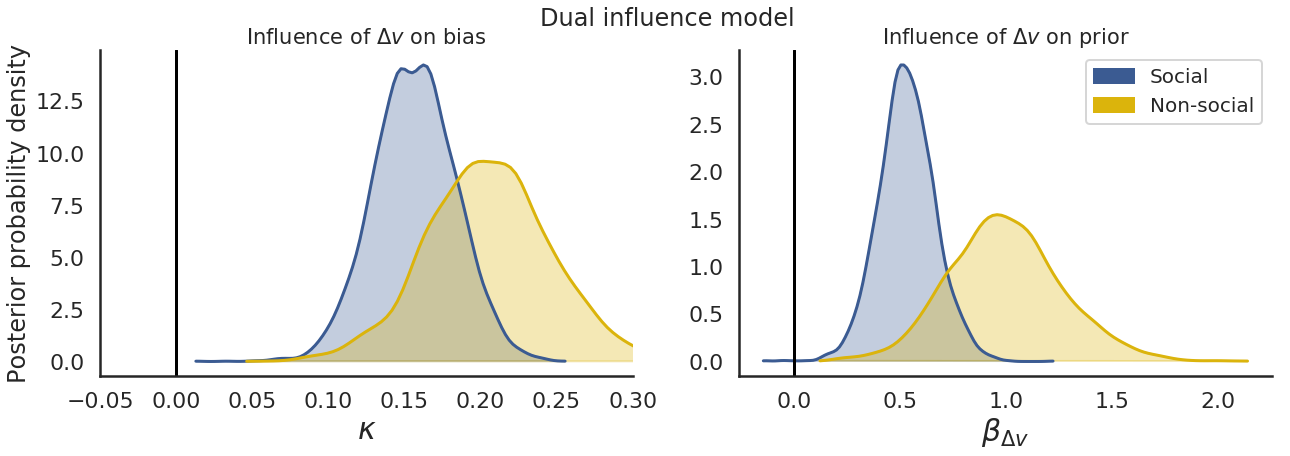

In [19]:
# dual influence model
sns.set_context("poster")
sns.set_style("white", {"grid.linewidth": 0})
pl.rcParams['figure.figsize'] = (21, 6)

social_patch = mpatches.Patch(color=sns.xkcd_rgb['denim blue'], label='Social')
non_social_patch = mpatches.Patch(color=sns.xkcd_rgb['gold'], label='Non-social')

fig, ax = pl.subplots(1,2,squeeze=False)
plt.suptitle('Dual influence model', size=24)
# param_plot(fit_dual_bayesian['insight_mean'], ax[0,2], color=sns.xkcd_rgb['denim blue'], fill_color=sns.xkcd_rgb['denim blue'], alpha=0.3)
# param_plot(fit_dual_bayesian_non_social['insight_mean'], ax[0,2], color=sns.xkcd_rgb['gold'], fill_color=sns.xkcd_rgb['gold'], alpha=0.3)
# ax[0,2].set_xlabel('$\\beta_{\\rho}$', size=30)
# ax[0,2].set_title('Influence of item popularity on prior', size=21)
# ax[0,2].axvline(x=0,color='black')
# ax[0,2].spines['right'].set_visible(False)
# ax[0,2].spines['top'].set_visible(False)
# #ax[0,2].set_ylim([0,14])
# #ax[0,2].set_xlim([-0.3,0.7])

param_plot(fit['cong_weight_prior_mean'], ax[0,1], color=sns.xkcd_rgb['denim blue'], fill_color=sns.xkcd_rgb['denim blue'], alpha=0.3)
param_plot(fit_nonsocial['cong_weight_prior_mean'], ax[0,1], color=sns.xkcd_rgb['gold'], fill_color=sns.xkcd_rgb['gold'], alpha=0.3)
#ax[0,1].set_ylabel('Frequency')
ax[0,1].set_xlabel('$\\beta_{\Delta v}$', size=30)
ax[0,1].set_title('Influence of $\Delta v$ on prior', size=21)
ax[0,1].axvline(x=0,color='black')
ax[0,1].legend(handles=[social_patch, non_social_patch], loc=1, fontsize=20)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)
#ax[0,1].set_ylim([0,14])
#ax[0,1].set_xlim([-0.3,0.7])

param_plot(fit['cong_weight_drift_bias_mean'], ax[0,0], color=sns.xkcd_rgb['denim blue'], fill_color=sns.xkcd_rgb['denim blue'], alpha=0.3)
param_plot(fit_nonsocial['cong_weight_drift_bias_mean'], ax[0,0], color=sns.xkcd_rgb['gold'], fill_color=sns.xkcd_rgb['gold'], alpha=0.3)
ax[0,0].set_ylabel('Posterior probability density')
ax[0,0].set_xlabel('$\kappa$', size=30)
ax[0,0].set_title('Influence of $\Delta v$ on bias', size=21)
ax[0,0].axvline(x=0,color='black')
#ax[0,0].set_ylim([0,14])
ax[0,0].set_xlim([-0.05,0.3])
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['top'].set_visible(False)



plt.savefig('../figures/fig2a-parameter_estimate_dual_group_means_triptych_two_groups.pdf', bbox_inches='tight')

Dual influence & popularity prior model

In [13]:
model = pickle.load(open('stan/pickles/model_dual_insight_prior_bayesian.pkl', 'rb'))
fit = pickle.load(open('stan/pickles/fit_dual_insight_prior_bayesian.pkl', 'rb'))

In [14]:
model_nonsocial = pickle.load(open('stan/pickles/model_dual_insight_prior_bayesian_non_social.pkl', 'rb'))
fit_nonsocial = pickle.load(open('stan/pickles/fit_dual_insight_prior_bayesian_non_social.pkl', 'rb'))

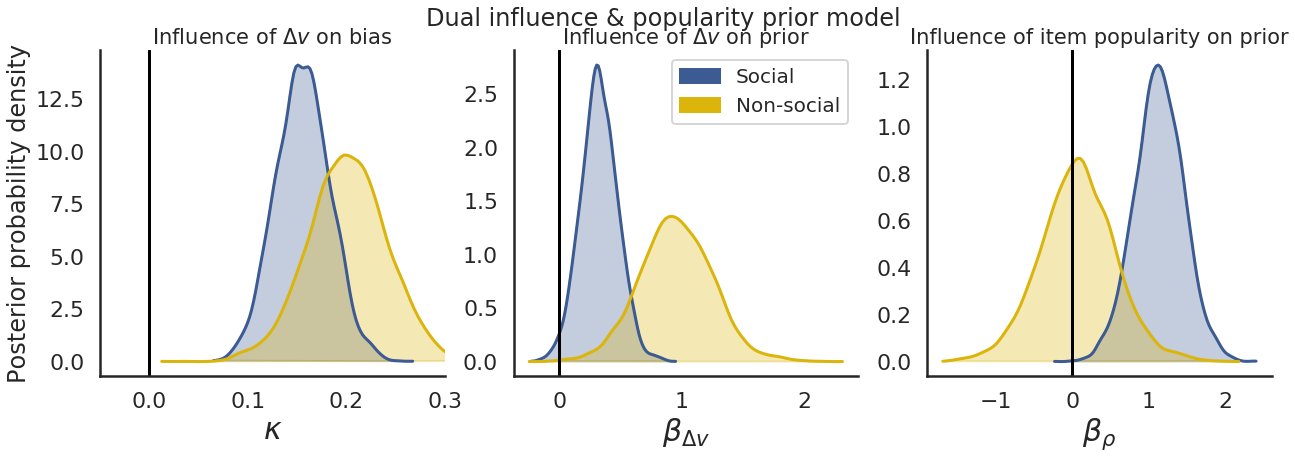

In [16]:
# dual influence w/ influence of popularity on prior model
sns.set_context("poster")
sns.set_style("white", {"grid.linewidth": 0})
pl.rcParams['figure.figsize'] = (21, 6)

social_patch = mpatches.Patch(color=sns.xkcd_rgb['denim blue'], label='Social')
non_social_patch = mpatches.Patch(color=sns.xkcd_rgb['gold'], label='Non-social')

fig, ax = pl.subplots(1,3,squeeze=False)
plt.suptitle('Dual influence & popularity prior model ', size=24)
param_plot(fit['insight_mean'], ax[0,2], color=sns.xkcd_rgb['denim blue'], fill_color=sns.xkcd_rgb['denim blue'], alpha=0.3)
param_plot(fit_nonsocial['insight_mean'], ax[0,2], color=sns.xkcd_rgb['gold'], fill_color=sns.xkcd_rgb['gold'], alpha=0.3)
ax[0,2].set_xlabel('$\\beta_{\\rho}$', size=30)
ax[0,2].set_title('Influence of item popularity on prior', size=21)
ax[0,2].axvline(x=0,color='black')
ax[0,2].spines['right'].set_visible(False)
ax[0,2].spines['top'].set_visible(False)
#ax[0,2].set_ylim([0,14])
#ax[0,2].set_xlim([-0.3,0.7])

param_plot(fit['cong_weight_prior_mean'], ax[0,1], color=sns.xkcd_rgb['denim blue'], fill_color=sns.xkcd_rgb['denim blue'], alpha=0.3)
param_plot(fit_nonsocial['cong_weight_prior_mean'], ax[0,1], color=sns.xkcd_rgb['gold'], fill_color=sns.xkcd_rgb['gold'], alpha=0.3)
#ax[0,1].set_ylabel('Frequency')
ax[0,1].set_xlabel('$\\beta_{\Delta v}$', size=30)
ax[0,1].set_title('Influence of $\Delta v$ on prior', size=21)
ax[0,1].axvline(x=0,color='black')
ax[0,1].legend(handles=[social_patch, non_social_patch], loc=1, fontsize=20)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)
#ax[0,1].set_ylim([0,14])
#ax[0,1].set_xlim([-0.3,0.7])

param_plot(fit['cong_weight_drift_bias_mean'], ax[0,0], color=sns.xkcd_rgb['denim blue'], fill_color=sns.xkcd_rgb['denim blue'], alpha=0.3)
param_plot(fit_nonsocial['cong_weight_drift_bias_mean'], ax[0,0], color=sns.xkcd_rgb['gold'], fill_color=sns.xkcd_rgb['gold'], alpha=0.3)
ax[0,0].set_ylabel('Posterior probability density')
ax[0,0].set_xlabel('$\kappa$', size=30)
ax[0,0].set_title('Influence of $\Delta v$ on bias', size=21)
ax[0,0].axvline(x=0,color='black')
#ax[0,0].set_ylim([0,14])
ax[0,0].set_xlim([-0.05,0.3])
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['top'].set_visible(False)



plt.savefig('../figures/fig2b-parameter_estimate_insightprior_group_means_triptych_two_groups.pdf', bbox_inches='tight')

##Figure 3: Data/model prediction plots

In [38]:
data_rt[(data_rt.inf_bid_dv>0)].infer_resp_rt.mean()

1.0864458606164502

In [39]:
data_rt[(data_rt.inf_bid_dv<0)].infer_resp_rt.mean()

1.1594067592594415

Null model

In [46]:
model = pickle.load(open('stan/pickles/model_null_bayesian.pkl', 'rb'))
fit = pickle.load(open('stan/pickles/fit_null_bayesian.pkl', 'rb'))

In [47]:
# SOCIAL (DUAL INFLUENCE w/INSIGHT, BAYESIAN)

# Generate model predictions from Stan fit
fit_df = pd.DataFrame(fit['log_lik_resp']).transpose()

pred_data_social = data_wpref.copy()
pred_data_social = pred_data_social[pred_data_social['block_loop_thisN'].notnull() & pred_data_social['img_correct'].notnull()]
pred_data_social = pred_data_social.reset_index(drop=True)

pred_data_social['lik_fit_dual_insight_bayesian_noeye'] = np.exp(fit_df.mean(axis=1))
pred_data_social.loc[(pred_data_social['response_correct']==1),'pred_fit_dual_insight_bayesian_noeye'] = pred_data_social['lik_fit_dual_insight_bayesian_noeye']
pred_data_social.loc[(pred_data_social['response_correct']==0),'pred_fit_dual_insight_bayesian_noeye'] = 1 - pred_data_social['lik_fit_dual_insight_bayesian_noeye']

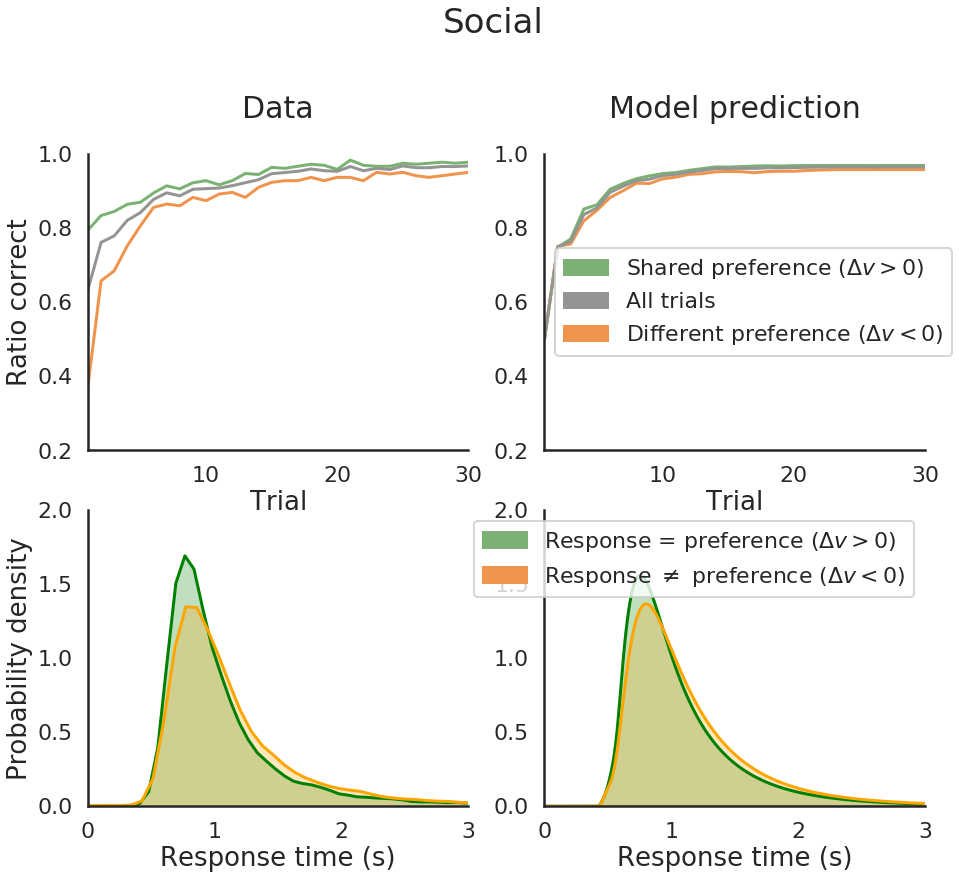

In [48]:
# Code for plot
model_means_cong = pred_data_social[pred_data_social['inf_bid_dv']>0].groupby(['pair_rep']).pred_fit_dual_insight_bayesian_noeye.mean()
model_means_incong = pred_data_social[pred_data_social['inf_bid_dv']<0].groupby(['pair_rep']).pred_fit_dual_insight_bayesian_noeye.mean()
model_means_all = pred_data_social.groupby(['pair_rep']).pred_fit_dual_insight_bayesian_noeye.mean()

data_means_cong = pred_data_social[pred_data_social['inf_bid_dv']>0].groupby(['pair_rep']).response_correct.mean()
data_means_incong = pred_data_social[pred_data_social['inf_bid_dv']<0].groupby(['pair_rep']).response_correct.mean()
data_means_all = pred_data_social.groupby(['pair_rep']).response_correct.mean()

in_patch = mpatches.Patch(color=sns.xkcd_rgb['faded orange'], label='Different preference ($\Delta v< 0$)')
con_patch = mpatches.Patch(color=sns.xkcd_rgb['faded green'], label='Shared preference ($\Delta v> 0$)')
tot_patch = mpatches.Patch(color=sns.xkcd_rgb['grey'], label='All trials')

sns.set_context("poster")
sns.set_style("white", {"grid.linewidth": 0})

pl.rcParams['figure.figsize'] = (15.0, 12.0) # Make the inline plot image bigger
plt.suptitle('Social', size=34, y=1.05)

ax1 = plt.subplot(221)
plt.plot(range(1,31),data_means_cong, color=sns.xkcd_rgb['faded green']), plt.plot(range(1,31),data_means_incong, color=sns.xkcd_rgb['faded orange']), plt.plot(range(1,31),data_means_all, color=sns.xkcd_rgb['grey'])
plt.axis([1,30,0.2,1])
plt.title('Data', fontsize=30, y=1.1)
plt.xlabel('Trial', fontsize=26)
plt.ylabel('Ratio correct', fontsize=26)
#plt.legend(handles=[con_patch, tot_patch, in_patch], loc=4)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)


ax2 = plt.subplot(222)
plt.plot(range(1,31),model_means_cong, color=sns.xkcd_rgb['faded green']), plt.plot(range(1,31),model_means_incong, color=sns.xkcd_rgb['faded orange']), plt.plot(range(1,31),model_means_all, color=sns.xkcd_rgb['grey'])
plt.axis([1,30,0.2,1])
plt.title('Model prediction', fontsize=30, y=1.1)
plt.xlabel('Trial', fontsize=26)
#plt.ylabel('Ratio correct', fontsize=26)
plt.legend(handles=[con_patch, tot_patch, in_patch], loc=6)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


in_patch = mpatches.Patch(color=sns.xkcd_rgb['faded orange'], label='Response $\\neq$ preference ($\Delta v< 0$)')
con_patch = mpatches.Patch(color=sns.xkcd_rgb['faded green'], label='Response = preference ($\Delta v> 0$)')

ax3 = plt.subplot(223)
sns.kdeplot(data_rt[(data_rt.response_matches_preference_bid==1)].infer_resp_rt, color='green', shade=True, linewidth=3, legend=False)
sns.kdeplot(data_rt[(data_rt.response_matches_preference_bid==0)].infer_resp_rt, color='orange', shade=True, linewidth=3, legend=False)
ax3.set(xlim=(0, 3))
plt.xlabel('Response time (s)', fontsize=26)
plt.ylabel('Probability density',fontsize=26)
plt.axis([0,3,0,2])
#plt.title('Social', size=34, position=[0.5,1.05])
#plt.legend(handles=[con_patch, in_patch], loc=1)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

ax4 = plt.subplot(224)
plt.plot(np.arange(0,10.58,0.01), pdfs_cong_all_social.mean(axis=0), color='green', linewidth=3)
plt.fill(np.arange(0,10.58,0.01), pdfs_cong_all_social.mean(axis=0), alpha=0.25, color='green')
plt.plot(np.arange(0,10.58,0.01), pdfs_incong_all_social.mean(axis=0), color='orange', linewidth=3)
plt.fill(np.arange(0,10.58,0.01), pdfs_incong_all_social.mean(axis=0), alpha=0.25, color='orange')
ax4.set(xlim=(0, 3))
#ax4.set_title('Data',fontsize=30)
plt.xlabel('Response time (s)', fontsize=26)
#plt.ylabel('Probability Density',fontsize=26)
plt.axis([0,3,0,2])
#plt.title('Social', size=34, position=[0.5,1.05])
plt.legend(handles=[con_patch, in_patch], loc=1)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

plt.savefig('../figures/fig3a-model_prediction_null_insight_social.pdf', bbox_inches='tight')

Dual influence model

In [54]:
model = pickle.load(open('stan/pickles/model_dual_bayesian.pkl', 'rb'))
fit = pickle.load(open('stan/pickles/fit_dual_bayesian.pkl', 'rb'))

In [55]:
# SOCIAL (DUAL INFLUENCE w/INSIGHT, BAYESIAN)

# Generate model predictions from Stan fit
fit_df = pd.DataFrame(fit['log_lik_resp']).transpose()

pred_data_social = data_wpref.copy()
pred_data_social = pred_data_social[pred_data_social['block_loop_thisN'].notnull() & pred_data_social['img_correct'].notnull()]
pred_data_social = pred_data_social.reset_index(drop=True)

pred_data_social['lik_fit_dual_insight_bayesian_noeye'] = np.exp(fit_df.mean(axis=1))
pred_data_social.loc[(pred_data_social['response_correct']==1),'pred_fit_dual_insight_bayesian_noeye'] = pred_data_social['lik_fit_dual_insight_bayesian_noeye']
pred_data_social.loc[(pred_data_social['response_correct']==0),'pred_fit_dual_insight_bayesian_noeye'] = 1 - pred_data_social['lik_fit_dual_insight_bayesian_noeye']

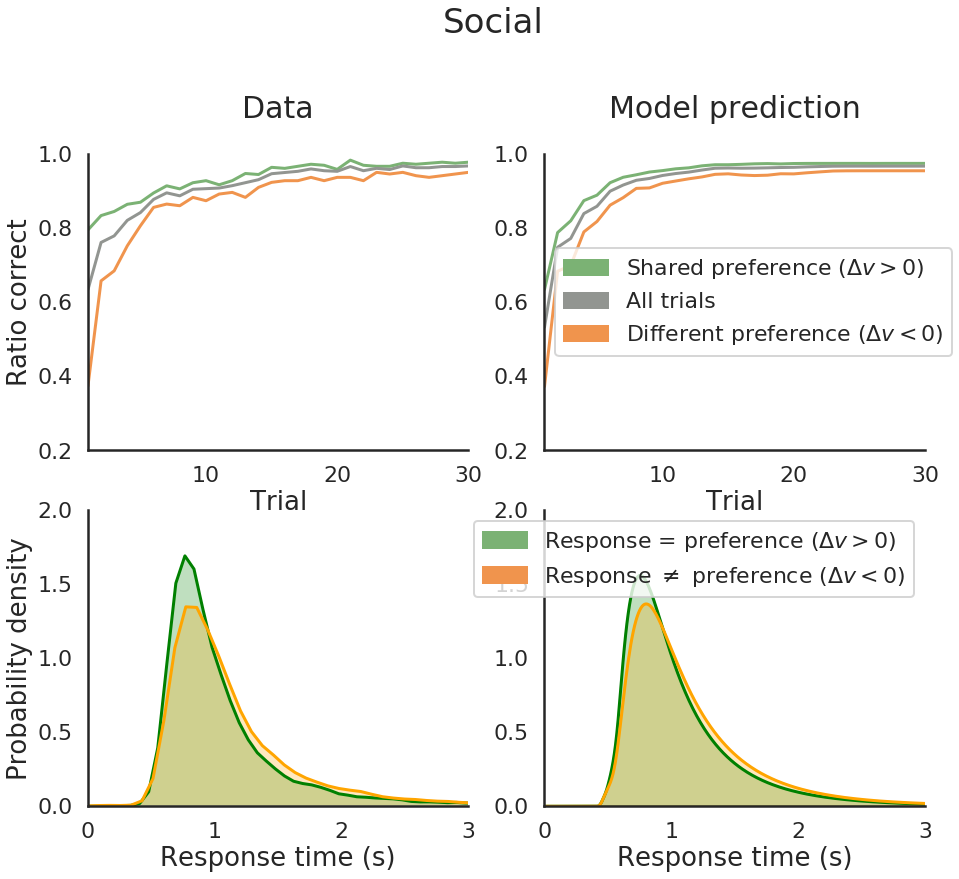

In [56]:
# Code for plot
model_means_cong = pred_data_social[pred_data_social['inf_bid_dv']>0].groupby(['pair_rep']).pred_fit_dual_insight_bayesian_noeye.mean()
model_means_incong = pred_data_social[pred_data_social['inf_bid_dv']<0].groupby(['pair_rep']).pred_fit_dual_insight_bayesian_noeye.mean()
model_means_all = pred_data_social.groupby(['pair_rep']).pred_fit_dual_insight_bayesian_noeye.mean()

data_means_cong = pred_data_social[pred_data_social['inf_bid_dv']>0].groupby(['pair_rep']).response_correct.mean()
data_means_incong = pred_data_social[pred_data_social['inf_bid_dv']<0].groupby(['pair_rep']).response_correct.mean()
data_means_all = pred_data_social.groupby(['pair_rep']).response_correct.mean()

in_patch = mpatches.Patch(color=sns.xkcd_rgb['faded orange'], label='Different preference ($\Delta v< 0$)')
con_patch = mpatches.Patch(color=sns.xkcd_rgb['faded green'], label='Shared preference ($\Delta v> 0$)')
tot_patch = mpatches.Patch(color=sns.xkcd_rgb['grey'], label='All trials')

sns.set_context("poster")
sns.set_style("white", {"grid.linewidth": 0})

pl.rcParams['figure.figsize'] = (15.0, 12.0) # Make the inline plot image bigger
plt.suptitle('Social', size=34, y=1.05)

ax1 = plt.subplot(221)
plt.plot(range(1,31),data_means_cong, color=sns.xkcd_rgb['faded green']), plt.plot(range(1,31),data_means_incong, color=sns.xkcd_rgb['faded orange']), plt.plot(range(1,31),data_means_all, color=sns.xkcd_rgb['grey'])
plt.axis([1,30,0.2,1])
plt.title('Data', fontsize=30, y=1.1)
plt.xlabel('Trial', fontsize=26)
plt.ylabel('Ratio correct', fontsize=26)
#plt.legend(handles=[con_patch, tot_patch, in_patch], loc=4)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)


ax2 = plt.subplot(222)
plt.plot(range(1,31),model_means_cong, color=sns.xkcd_rgb['faded green']), plt.plot(range(1,31),model_means_incong, color=sns.xkcd_rgb['faded orange']), plt.plot(range(1,31),model_means_all, color=sns.xkcd_rgb['grey'])
plt.axis([1,30,0.2,1])
plt.title('Model prediction', fontsize=30, y=1.1)
plt.xlabel('Trial', fontsize=26)
#plt.ylabel('Ratio correct', fontsize=26)
plt.legend(handles=[con_patch, tot_patch, in_patch], loc=6)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


in_patch = mpatches.Patch(color=sns.xkcd_rgb['faded orange'], label='Response $\\neq$ preference ($\Delta v< 0$)')
con_patch = mpatches.Patch(color=sns.xkcd_rgb['faded green'], label='Response = preference ($\Delta v> 0$)')

ax3 = plt.subplot(223)
sns.kdeplot(data_rt[(data_rt.response_matches_preference_bid==1)].infer_resp_rt, color='green', shade=True, linewidth=3, legend=False)
sns.kdeplot(data_rt[(data_rt.response_matches_preference_bid==0)].infer_resp_rt, color='orange', shade=True, linewidth=3, legend=False)
ax3.set(xlim=(0, 3))
plt.xlabel('Response time (s)', fontsize=26)
plt.ylabel('Probability density',fontsize=26)
plt.axis([0,3,0,2])
#plt.title('Social', size=34, position=[0.5,1.05])
#plt.legend(handles=[con_patch, in_patch], loc=1)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

ax4 = plt.subplot(224)
plt.plot(np.arange(0,10.58,0.01), pdfs_cong_all_social.mean(axis=0), color='green', linewidth=3)
plt.fill(np.arange(0,10.58,0.01), pdfs_cong_all_social.mean(axis=0), alpha=0.25, color='green')
plt.plot(np.arange(0,10.58,0.01), pdfs_incong_all_social.mean(axis=0), color='orange', linewidth=3)
plt.fill(np.arange(0,10.58,0.01), pdfs_incong_all_social.mean(axis=0), alpha=0.25, color='orange')
ax4.set(xlim=(0, 3))
#ax4.set_title('Data',fontsize=30)
plt.xlabel('Response time (s)', fontsize=26)
#plt.ylabel('Probability Density',fontsize=26)
plt.axis([0,3,0,2])
#plt.title('Social', size=34, position=[0.5,1.05])
plt.legend(handles=[con_patch, in_patch], loc=1)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

plt.savefig('../figures/fig3b-model_prediction_dual_social.pdf', bbox_inches='tight')

Dual influence & popularity prior model

In [50]:
model = pickle.load(open('stan/pickles/model_dual_insight_prior_bayesian.pkl', 'rb'))
fit = pickle.load(open('stan/pickles/fit_dual_insight_prior_bayesian.pkl', 'rb'))

In [51]:
# SOCIAL (DUAL INFLUENCE w/INSIGHT, BAYESIAN)

# Generate model predictions from Stan fit
fit_df = pd.DataFrame(fit['log_lik_resp']).transpose()

pred_data_social = data_wpref.copy()
pred_data_social = pred_data_social[pred_data_social['block_loop_thisN'].notnull() & pred_data_social['img_correct'].notnull()]
pred_data_social = pred_data_social.reset_index(drop=True)

pred_data_social['lik_fit_dual_insight_bayesian_noeye'] = np.exp(fit_df.mean(axis=1))
pred_data_social.loc[(pred_data_social['response_correct']==1),'pred_fit_dual_insight_bayesian_noeye'] = pred_data_social['lik_fit_dual_insight_bayesian_noeye']
pred_data_social.loc[(pred_data_social['response_correct']==0),'pred_fit_dual_insight_bayesian_noeye'] = 1 - pred_data_social['lik_fit_dual_insight_bayesian_noeye']

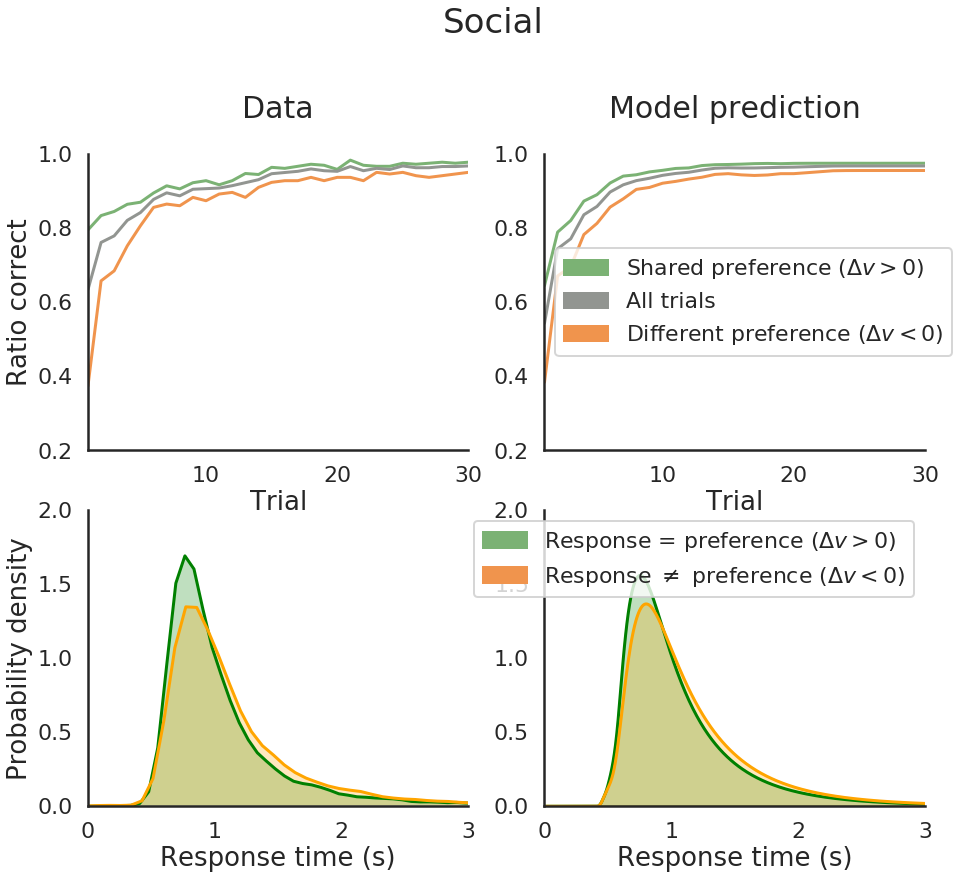

In [53]:
# Code for plot
model_means_cong = pred_data_social[pred_data_social['inf_bid_dv']>0].groupby(['pair_rep']).pred_fit_dual_insight_bayesian_noeye.mean()
model_means_incong = pred_data_social[pred_data_social['inf_bid_dv']<0].groupby(['pair_rep']).pred_fit_dual_insight_bayesian_noeye.mean()
model_means_all = pred_data_social.groupby(['pair_rep']).pred_fit_dual_insight_bayesian_noeye.mean()

data_means_cong = pred_data_social[pred_data_social['inf_bid_dv']>0].groupby(['pair_rep']).response_correct.mean()
data_means_incong = pred_data_social[pred_data_social['inf_bid_dv']<0].groupby(['pair_rep']).response_correct.mean()
data_means_all = pred_data_social.groupby(['pair_rep']).response_correct.mean()

in_patch = mpatches.Patch(color=sns.xkcd_rgb['faded orange'], label='Different preference ($\Delta v< 0$)')
con_patch = mpatches.Patch(color=sns.xkcd_rgb['faded green'], label='Shared preference ($\Delta v> 0$)')
tot_patch = mpatches.Patch(color=sns.xkcd_rgb['grey'], label='All trials')

sns.set_context("poster")
sns.set_style("white", {"grid.linewidth": 0})

pl.rcParams['figure.figsize'] = (15.0, 12.0) # Make the inline plot image bigger
plt.suptitle('Social', size=34, y=1.05)

ax1 = plt.subplot(221)
plt.plot(range(1,31),data_means_cong, color=sns.xkcd_rgb['faded green']), plt.plot(range(1,31),data_means_incong, color=sns.xkcd_rgb['faded orange']), plt.plot(range(1,31),data_means_all, color=sns.xkcd_rgb['grey'])
plt.axis([1,30,0.2,1])
plt.title('Data', fontsize=30, y=1.1)
plt.xlabel('Trial', fontsize=26)
plt.ylabel('Ratio correct', fontsize=26)
#plt.legend(handles=[con_patch, tot_patch, in_patch], loc=4)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)


ax2 = plt.subplot(222)
plt.plot(range(1,31),model_means_cong, color=sns.xkcd_rgb['faded green']), plt.plot(range(1,31),model_means_incong, color=sns.xkcd_rgb['faded orange']), plt.plot(range(1,31),model_means_all, color=sns.xkcd_rgb['grey'])
plt.axis([1,30,0.2,1])
plt.title('Model prediction', fontsize=30, y=1.1)
plt.xlabel('Trial', fontsize=26)
#plt.ylabel('Ratio correct', fontsize=26)
plt.legend(handles=[con_patch, tot_patch, in_patch], loc=6)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


in_patch = mpatches.Patch(color=sns.xkcd_rgb['faded orange'], label='Response $\\neq$ preference ($\Delta v< 0$)')
con_patch = mpatches.Patch(color=sns.xkcd_rgb['faded green'], label='Response = preference ($\Delta v> 0$)')

ax3 = plt.subplot(223)
sns.kdeplot(data_rt[(data_rt.response_matches_preference_bid==1)].infer_resp_rt, color='green', shade=True, linewidth=3, legend=False)
sns.kdeplot(data_rt[(data_rt.response_matches_preference_bid==0)].infer_resp_rt, color='orange', shade=True, linewidth=3, legend=False)
ax3.set(xlim=(0, 3))
plt.xlabel('Response time (s)', fontsize=26)
plt.ylabel('Probability density',fontsize=26)
plt.axis([0,3,0,2])
#plt.title('Social', size=34, position=[0.5,1.05])
#plt.legend(handles=[con_patch, in_patch], loc=1)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

ax4 = plt.subplot(224)
plt.plot(np.arange(0,10.58,0.01), pdfs_cong_all_social.mean(axis=0), color='green', linewidth=3)
plt.fill(np.arange(0,10.58,0.01), pdfs_cong_all_social.mean(axis=0), alpha=0.25, color='green')
plt.plot(np.arange(0,10.58,0.01), pdfs_incong_all_social.mean(axis=0), color='orange', linewidth=3)
plt.fill(np.arange(0,10.58,0.01), pdfs_incong_all_social.mean(axis=0), alpha=0.25, color='orange')
ax4.set(xlim=(0, 3))
#ax4.set_title('Data',fontsize=30)
plt.xlabel('Response time (s)', fontsize=26)
#plt.ylabel('Probability Density',fontsize=26)
plt.axis([0,3,0,2])
#plt.title('Social', size=34, position=[0.5,1.05])
plt.legend(handles=[con_patch, in_patch], loc=1)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

plt.savefig('../figures/fig3c-model_prediction_dual_insightprior_social.pdf', bbox_inches='tight')

Dual influence & popularity bias model

In [57]:
model = pickle.load(open('stan/pickles/model_dual_insight_bias_bayesian.pkl', 'rb'))
fit = pickle.load(open('stan/pickles/fit_dual_insight_bias_bayesian.pkl', 'rb'))

In [58]:
# SOCIAL (DUAL INFLUENCE w/INSIGHT, BAYESIAN)

# Generate model predictions from Stan fit
fit_df = pd.DataFrame(fit['log_lik_resp']).transpose()

pred_data_social = data_wpref.copy()
pred_data_social = pred_data_social[pred_data_social['block_loop_thisN'].notnull() & pred_data_social['img_correct'].notnull()]
pred_data_social = pred_data_social.reset_index(drop=True)

pred_data_social['lik_fit_dual_insight_bayesian_noeye'] = np.exp(fit_df.mean(axis=1))
pred_data_social.loc[(pred_data_social['response_correct']==1),'pred_fit_dual_insight_bayesian_noeye'] = pred_data_social['lik_fit_dual_insight_bayesian_noeye']
pred_data_social.loc[(pred_data_social['response_correct']==0),'pred_fit_dual_insight_bayesian_noeye'] = 1 - pred_data_social['lik_fit_dual_insight_bayesian_noeye']

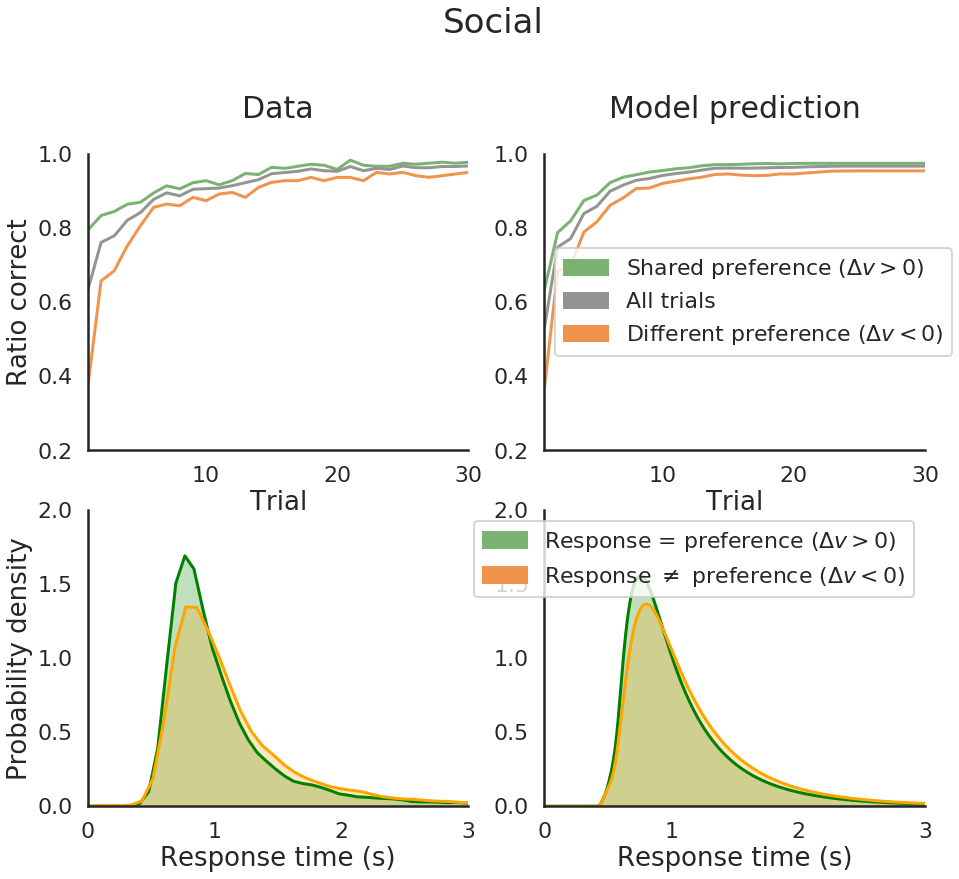

In [59]:
# Code for plot
model_means_cong = pred_data_social[pred_data_social['inf_bid_dv']>0].groupby(['pair_rep']).pred_fit_dual_insight_bayesian_noeye.mean()
model_means_incong = pred_data_social[pred_data_social['inf_bid_dv']<0].groupby(['pair_rep']).pred_fit_dual_insight_bayesian_noeye.mean()
model_means_all = pred_data_social.groupby(['pair_rep']).pred_fit_dual_insight_bayesian_noeye.mean()

data_means_cong = pred_data_social[pred_data_social['inf_bid_dv']>0].groupby(['pair_rep']).response_correct.mean()
data_means_incong = pred_data_social[pred_data_social['inf_bid_dv']<0].groupby(['pair_rep']).response_correct.mean()
data_means_all = pred_data_social.groupby(['pair_rep']).response_correct.mean()

in_patch = mpatches.Patch(color=sns.xkcd_rgb['faded orange'], label='Different preference ($\Delta v< 0$)')
con_patch = mpatches.Patch(color=sns.xkcd_rgb['faded green'], label='Shared preference ($\Delta v> 0$)')
tot_patch = mpatches.Patch(color=sns.xkcd_rgb['grey'], label='All trials')

sns.set_context("poster")
sns.set_style("white", {"grid.linewidth": 0})

pl.rcParams['figure.figsize'] = (15.0, 12.0) # Make the inline plot image bigger
plt.suptitle('Social', size=34, y=1.05)

ax1 = plt.subplot(221)
plt.plot(range(1,31),data_means_cong, color=sns.xkcd_rgb['faded green']), plt.plot(range(1,31),data_means_incong, color=sns.xkcd_rgb['faded orange']), plt.plot(range(1,31),data_means_all, color=sns.xkcd_rgb['grey'])
plt.axis([1,30,0.2,1])
plt.title('Data', fontsize=30, y=1.1)
plt.xlabel('Trial', fontsize=26)
plt.ylabel('Ratio correct', fontsize=26)
#plt.legend(handles=[con_patch, tot_patch, in_patch], loc=4)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)


ax2 = plt.subplot(222)
plt.plot(range(1,31),model_means_cong, color=sns.xkcd_rgb['faded green']), plt.plot(range(1,31),model_means_incong, color=sns.xkcd_rgb['faded orange']), plt.plot(range(1,31),model_means_all, color=sns.xkcd_rgb['grey'])
plt.axis([1,30,0.2,1])
plt.title('Model prediction', fontsize=30, y=1.1)
plt.xlabel('Trial', fontsize=26)
#plt.ylabel('Ratio correct', fontsize=26)
plt.legend(handles=[con_patch, tot_patch, in_patch], loc=6)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


in_patch = mpatches.Patch(color=sns.xkcd_rgb['faded orange'], label='Response $\\neq$ preference ($\Delta v< 0$)')
con_patch = mpatches.Patch(color=sns.xkcd_rgb['faded green'], label='Response = preference ($\Delta v> 0$)')

ax3 = plt.subplot(223)
sns.kdeplot(data_rt[(data_rt.response_matches_preference_bid==1)].infer_resp_rt, color='green', shade=True, linewidth=3, legend=False)
sns.kdeplot(data_rt[(data_rt.response_matches_preference_bid==0)].infer_resp_rt, color='orange', shade=True, linewidth=3, legend=False)
ax3.set(xlim=(0, 3))
plt.xlabel('Response time (s)', fontsize=26)
plt.ylabel('Probability density',fontsize=26)
plt.axis([0,3,0,2])
#plt.title('Social', size=34, position=[0.5,1.05])
#plt.legend(handles=[con_patch, in_patch], loc=1)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

ax4 = plt.subplot(224)
plt.plot(np.arange(0,10.58,0.01), pdfs_cong_all_social.mean(axis=0), color='green', linewidth=3)
plt.fill(np.arange(0,10.58,0.01), pdfs_cong_all_social.mean(axis=0), alpha=0.25, color='green')
plt.plot(np.arange(0,10.58,0.01), pdfs_incong_all_social.mean(axis=0), color='orange', linewidth=3)
plt.fill(np.arange(0,10.58,0.01), pdfs_incong_all_social.mean(axis=0), alpha=0.25, color='orange')
ax4.set(xlim=(0, 3))
#ax4.set_title('Data',fontsize=30)
plt.xlabel('Response time (s)', fontsize=26)
#plt.ylabel('Probability Density',fontsize=26)
plt.axis([0,3,0,2])
#plt.title('Social', size=34, position=[0.5,1.05])
plt.legend(handles=[con_patch, in_patch], loc=1)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

plt.savefig('../figures/fig3d-model_prediction_dual_insightbias_social.pdf', bbox_inches='tight')

Dual influence & popularity priorbias model

In [60]:
model = pickle.load(open('stan/pickles/model_dual_insight_priorbias_bayesian.pkl', 'rb'))
fit = pickle.load(open('stan/pickles/fit_dual_insight_priorbias_bayesian.pkl', 'rb'))

In [61]:
# SOCIAL (DUAL INFLUENCE w/INSIGHT, BAYESIAN)

# Generate model predictions from Stan fit
fit_df = pd.DataFrame(fit['log_lik_resp']).transpose()

pred_data_social = data_wpref.copy()
pred_data_social = pred_data_social[pred_data_social['block_loop_thisN'].notnull() & pred_data_social['img_correct'].notnull()]
pred_data_social = pred_data_social.reset_index(drop=True)

pred_data_social['lik_fit_dual_insight_bayesian_noeye'] = np.exp(fit_df.mean(axis=1))
pred_data_social.loc[(pred_data_social['response_correct']==1),'pred_fit_dual_insight_bayesian_noeye'] = pred_data_social['lik_fit_dual_insight_bayesian_noeye']
pred_data_social.loc[(pred_data_social['response_correct']==0),'pred_fit_dual_insight_bayesian_noeye'] = 1 - pred_data_social['lik_fit_dual_insight_bayesian_noeye']

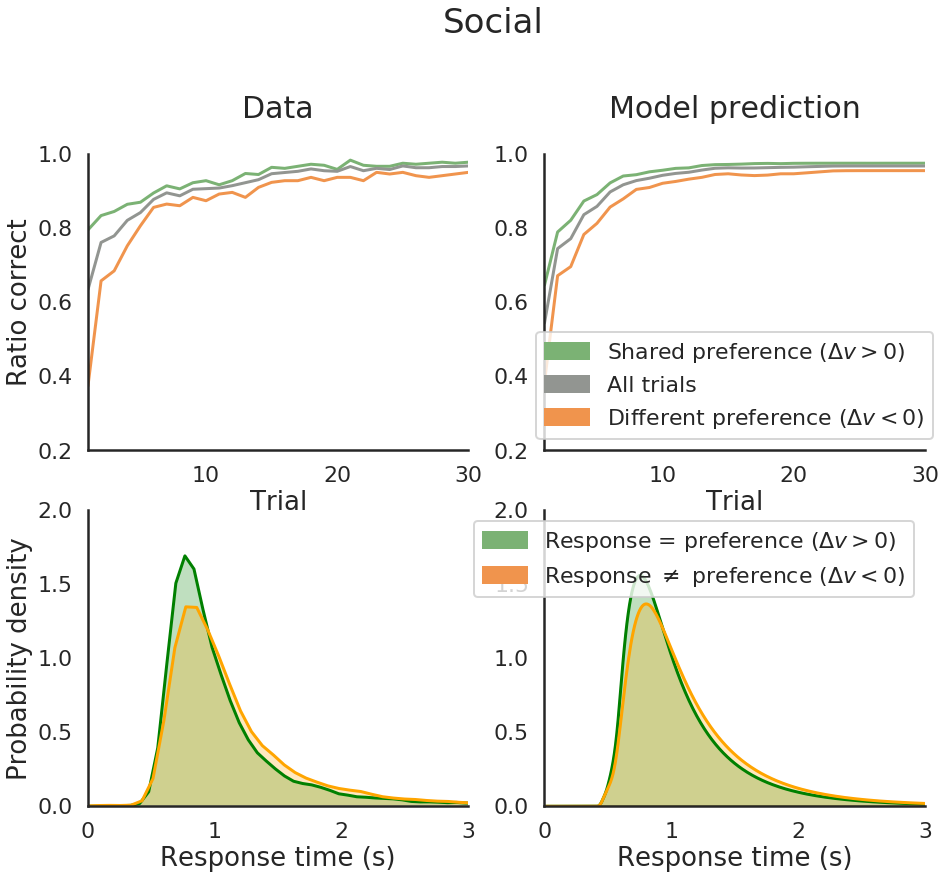

In [63]:
# Code for plot
model_means_cong = pred_data_social[pred_data_social['inf_bid_dv']>0].groupby(['pair_rep']).pred_fit_dual_insight_bayesian_noeye.mean()
model_means_incong = pred_data_social[pred_data_social['inf_bid_dv']<0].groupby(['pair_rep']).pred_fit_dual_insight_bayesian_noeye.mean()
model_means_all = pred_data_social.groupby(['pair_rep']).pred_fit_dual_insight_bayesian_noeye.mean()

data_means_cong = pred_data_social[pred_data_social['inf_bid_dv']>0].groupby(['pair_rep']).response_correct.mean()
data_means_incong = pred_data_social[pred_data_social['inf_bid_dv']<0].groupby(['pair_rep']).response_correct.mean()
data_means_all = pred_data_social.groupby(['pair_rep']).response_correct.mean()

in_patch = mpatches.Patch(color=sns.xkcd_rgb['faded orange'], label='Different preference ($\Delta v< 0$)')
con_patch = mpatches.Patch(color=sns.xkcd_rgb['faded green'], label='Shared preference ($\Delta v> 0$)')
tot_patch = mpatches.Patch(color=sns.xkcd_rgb['grey'], label='All trials')

sns.set_context("poster")
sns.set_style("white", {"grid.linewidth": 0})

pl.rcParams['figure.figsize'] = (15.0, 12.0) # Make the inline plot image bigger
plt.suptitle('Social', size=34, y=1.05)

ax1 = plt.subplot(221)
plt.plot(range(1,31),data_means_cong, color=sns.xkcd_rgb['faded green']), plt.plot(range(1,31),data_means_incong, color=sns.xkcd_rgb['faded orange']), plt.plot(range(1,31),data_means_all, color=sns.xkcd_rgb['grey'])
plt.axis([1,30,0.2,1])
plt.title('Data', fontsize=30, y=1.1)
plt.xlabel('Trial', fontsize=26)
plt.ylabel('Ratio correct', fontsize=26)
#plt.legend(handles=[con_patch, tot_patch, in_patch], loc=4)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)


ax2 = plt.subplot(222)
plt.plot(range(1,31),model_means_cong, color=sns.xkcd_rgb['faded green']), plt.plot(range(1,31),model_means_incong, color=sns.xkcd_rgb['faded orange']), plt.plot(range(1,31),model_means_all, color=sns.xkcd_rgb['grey'])
plt.axis([1,30,0.2,1])
plt.title('Model prediction', fontsize=30, y=1.1)
plt.xlabel('Trial', fontsize=26)
#plt.ylabel('Ratio correct', fontsize=26)
plt.legend(handles=[con_patch, tot_patch, in_patch], loc=8)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


in_patch = mpatches.Patch(color=sns.xkcd_rgb['faded orange'], label='Response $\\neq$ preference ($\Delta v< 0$)')
con_patch = mpatches.Patch(color=sns.xkcd_rgb['faded green'], label='Response = preference ($\Delta v> 0$)')

ax3 = plt.subplot(223)
sns.kdeplot(data_rt[(data_rt.response_matches_preference_bid==1)].infer_resp_rt, color='green', shade=True, linewidth=3, legend=False)
sns.kdeplot(data_rt[(data_rt.response_matches_preference_bid==0)].infer_resp_rt, color='orange', shade=True, linewidth=3, legend=False)
ax3.set(xlim=(0, 3))
plt.xlabel('Response time (s)', fontsize=26)
plt.ylabel('Probability density',fontsize=26)
plt.axis([0,3,0,2])
#plt.title('Social', size=34, position=[0.5,1.05])
#plt.legend(handles=[con_patch, in_patch], loc=1)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

ax4 = plt.subplot(224)
plt.plot(np.arange(0,10.58,0.01), pdfs_cong_all_social.mean(axis=0), color='green', linewidth=3)
plt.fill(np.arange(0,10.58,0.01), pdfs_cong_all_social.mean(axis=0), alpha=0.25, color='green')
plt.plot(np.arange(0,10.58,0.01), pdfs_incong_all_social.mean(axis=0), color='orange', linewidth=3)
plt.fill(np.arange(0,10.58,0.01), pdfs_incong_all_social.mean(axis=0), alpha=0.25, color='orange')
ax4.set(xlim=(0, 3))
#ax4.set_title('Data',fontsize=30)
plt.xlabel('Response time (s)', fontsize=26)
#plt.ylabel('Probability Density',fontsize=26)
plt.axis([0,3,0,2])
#plt.title('Social', size=34, position=[0.5,1.05])
plt.legend(handles=[con_patch, in_patch], loc=1)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

plt.savefig('../figures/fig3e-model_prediction_dual_insightpriorbias_social.pdf', bbox_inches='tight')

In [64]:
len(pred_data_social[pred_data_social['inf_bid_dv']>0])

10830

In [65]:
len(pred_data_social[pred_data_social['inf_bid_dv']<0])

6660